In [1]:
import os 
os.environ['MONOTOOLSPATH']='/Volumes/LUVOIR/MonoToolsData'

os.environ["THEANO_FLAGS"]="compiledir="+os.path.join(os.environ['MONOTOOLSPATH'],".theano_compile_dir_2")
os.system("mkdir "+os.path.join(os.environ['MONOTOOLSPATH'],".theano_compile_dir_2"))

import pickle
import numpy as np
import glob
import pandas as pd

from MonoTools import tools,search,starpars

from astropy.coordinates import SkyCoord
import astropy.units as u

%load_ext autoreload
%autoreload 2


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
import glob
infofiles=glob.glob("/Volumes/LUVOIR/MonoToolsData/*_CandMonoInfo.csv")
for file in infofiles:
     os.system("mv "+file+" "+"/".join(file.split("/")[:-1])+"/"+file.split("/")[-1].split("_")[0]+"/"+file.split("/")[-1])

In [3]:
cands=pd.read_csv("data/tables/2020_monos_unq.csv").loc[::-1]#.iloc[::2]

In [ ]:
get_qlps=[]
for ix,dat in cands.iterrows():
    try:
        gen_lc=False
        file_loc=tools.MonoData_savepath+'/'+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
        if not os.path.isdir(file_loc):
            os.system('mkdir '+file_loc)
        file_prefix=file_loc+"/"+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
        print("starting", int(dat['id']))

        if not os.path.isfile(file_prefix+'_lc.pickle'):
            gen_lc=True
        else:
            lc=pickle.load(open(file_prefix+'_lc.pickle','rb'))
            if 't30' in np.unique(lc['cadence']) or 't29' in np.unique(lc['cadence']):
                if len(glob.glob(file_loc+"/*.h5"))==0:
                    get_qlps+=[tools.id_dic[dat['mission']]+str(int(dat['id']))]
                    gen_lc=False
                gen_lc=True
            else:
                #Re-running those we claimed to be low-SNR
                df=pd.read_csv(file_prefix+"_CandMonoInfo.csv",index_col=0).T
                flag=df['flag'].values[0]
                print(int(dat['id']),flag)
                if flag!='planet':
                    gen_lc=True
        if gen_lc:
            if not pd.isnull(dat['ra']):
                radec=SkyCoord(float(dat['ra'])*u.deg,float(dat['dec'])*u.deg)
            else:
                radec=None
            #loading Rstar,Tess, logg and rho from csvs:
            if not os.path.isfile(file_prefix+'_starpars.csv'):
                info,_,_=starpars.getStellarInfoFromCsv(int(dat['id']),dat['mission'],radec=radec)
                info.to_csv(file_prefix+'_starpars.csv')
            else:
                #print("loading from ",file_prefix+'_starpars.csv')
                info=pd.read_csv(file_prefix+'_starpars.csv', index_col=0, header=0).T.iloc[0]
            if 'ra' in info.index and radec is None:
                radec=SkyCoord(float(info['ra'])*u.deg,float(info['dec'])*u.deg)
            Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
            Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
            logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
            rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
            FeH=0.0 if 'FeH' not in info else float(info['FeH'])
            if 'mass' in info:
                Ms=float(info['mass'])
            else:
                Ms=rhostar[0]*Rstar[0]**3

            if not os.path.isfile(file_prefix+'_lc.pickle'):
                #Gets Lightcurve
                lc,hdr=tools.openLightCurve(int(dat['id']),dat['mission'],coor=radec,use_ppt=False)
                pickle.dump(lc,open(file_prefix+'_lc.pickle','wb'))

            if 't30' in np.unique(lc['cadence']):
                if 'bg_flux' not in lc or np.all(np.isnan(lc['bg_flux'][lc['cadence']=='t30'])):
                    get_qlps+=[tools.id_dic[dat['mission']]+str(int(dat['id']))]
            if 't29' in np.unique(lc['cadence']):
                if 'bg_flux' not in lc or np.all(np.isnan(lc['bg_flux'][lc['cadence']=='t29'])):
                    get_qlps+=[tools.id_dic[dat['mission']]+str(int(dat['id']))]

            if np.min(abs(dat['tcen']-lc['time']))>dat['dur']:
                cand={'00':{'tcen':dat['tcen']-(7000-4833),'tdur':dat['dur'],'orbit_flag':'mono'}}    
            else:
                print("TCEN OF ",tools.id_dic[dat['mission']]+str(int(dat['id'])),"NOT CORRECT")
                cand={'00':{'tcen':dat['tcen'],'tdur':dat['dur'],'orbit_flag':'mono'}}
            
            if cand['00']['tcen']==0.0 or cand['00']['tcen']==2167.0 or cand['00']['tdur']==0.0:
                if cand['00']['tdur']==0.0 and cand['00']['tcen'] not in [0.0,2167.0]:
                    
                    cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],
                                                                  Rs=Rstar[0],Ms=Ms,Teff=Teff[0],plot=False,
                                                                  custom_mask=abs(lc['time']-dat['tcen'])<5)
                else:
                    cand, _, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],
                                                                  Ms=Ms,Teff=Teff[0],plot=False)
                    if Rs>1.75:
                        #Also searching with solar-like info:
                        cand2, _, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],plot=True)
                        if abs(cand['00']['tcen']-cand2['00']['tcen'])>0.5:
                            if cand2['00']['snr']>cand['00']['snr']:
                                cand2=cand
            if len(cand)==0:
                df=pd.Series({},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
            else:
                out, fig = search.VetCand(cand['00'],'00',dat['id'],lc,Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                       file_loc=file_loc,plot=True,vet_do_fit=True)
                floatvars=[var for var in out if type(out[var]) in [int,float,str,np.float64,np.float32]]
                df=pd.Series({var:out[var] for var in floatvars},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
            df.to_csv(file_prefix+"_CandMonoInfo.csv")
        else:
            print("Already processed",int(dat['id']))
    except:
        print("NO JUICE",int(dat['id']))

In [16]:
dat=cands.loc[cands['id']==158316873].iloc[0]
dat

Unnamed: 0                       3525
dec                               NaN
dur                          0.263889
file          Martti_Monos_Tess_South
id                        1.58317e+08
mission                          tess
ra                                NaN
tcen                          3855.99
Name: 2104, dtype: object

transit mask: <class 'numpy.ndarray'> 18654 0 <class 'numpy.ndarray'> 18654 True
True [[-6.32080078e-01 -8.92952695e-04  2.46825369e-04 -1.91989806e-04
   8.51265970e-04 -7.89208279e-05]
 [-6.30615234e-01  2.05247846e-03  2.46837191e-04 -1.82246062e-04
   8.46526935e-04 -7.90129634e-05]
 [-6.29272461e-01 -2.85339336e-03  2.46847964e-04 -1.73326262e-04
   8.42183013e-04 -7.90974227e-05]
 ...
 [ 6.30493164e-01  1.60322100e-03  2.29390701e-04 -5.46582567e-04
  -3.50923045e-04 -1.58335039e-04]
 [ 6.31835938e-01 -8.17857977e-04  2.29342714e-04 -5.55213657e-04
  -3.54376505e-04 -1.58419498e-04]
 [ 6.33300781e-01 -1.73105912e-03  2.29290292e-04 -5.64598711e-04
  -3.58143938e-04 -1.58511626e-04]]
6373 1288
True [[-4.49866191  0.72040275 -0.06838794  0.70061889  1.74723891]
 [-4.49727303  0.72309272 -0.06759716  0.70071782  1.74640491]
 [-4.49588414  0.72117959 -0.06679633  0.70081675  1.74557146]
 ...
 [ 4.49714614  1.48253146 -0.06993811  1.3413893   0.62925512]
 [ 4.49853502  1.48596911 -0.0

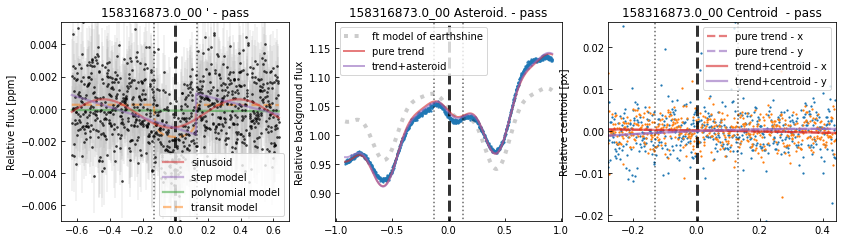

In [83]:
dat=cands.loc[cands['id']==158316873].iloc[0]
file_loc=tools.MonoData_savepath+'/'+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
file_prefix=file_loc+"/"+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
info=pd.read_csv(file_prefix+'_starpars.csv', index_col=0, header=0).T.iloc[0]
radec=SkyCoord(float(info['ra'])*u.deg,float(info['dec'])*u.deg)
Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
FeH=0.0 if 'FeH' not in info else float(info['FeH'])
Ms=float(info['mass'])

lc=pickle.load(open("/Volumes/LUVOIR/MonoToolsData/TIC00158316873/TIC00158316873_lc.pickle","rb"))

cand={'00':{'tcen':dat['tcen']-7000+4833,'tdur':dat['dur'],'orbit_flag':'mono'}}
out, fig = search.VetCand(cand['00'],'00',dat['id'],lc,Rs=Rstar[0],Ms=Ms,Teff=Teff[0], force_tdur=True,
                           file_loc=file_loc,plot=True,vet_do_fit=True,return_fit_lcs=True)

In [ ]:
for ix,dat in cands.iterrows():
    try:
        file_loc=tools.MonoData_savepath+'/'+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
        if not os.path.isdir(file_loc):
            os.system('mkdir '+file_loc)
        file_prefix=file_loc+"/"+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
        if os.path.isfile(file_prefix+"_CandMonoInfo.csv"):
            df=pd.read_csv(file_prefix+"_CandMonoInfo.csv",index_col=0).T
            rerun=df['flag'].values[0]=='asteroid'
        else:
            rerun=True
        if rerun:
            if not pd.isnull(dat['ra']):
                radec=SkyCoord(float(dat['ra'])*u.deg,float(dat['dec'])*u.deg)
            else:
                radec=None
            #loading Rstar,Tess, logg and rho from csvs:
            if not os.path.isfile(file_prefix+'_starpars.csv'):
                try:
                    info,_,_=starpars.getStellarInfoFromCsv(int(dat['id']),dat['mission'],radec=radec)
                    info.to_csv(file_prefix+'_starpars.csv')
                    Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
                    Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
                    logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
                    rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
                    FeH=0.0 if 'FeH' not in info else float(info['FeH'])
                    if 'mass' in info:
                        Ms=float(info['mass'])
                    else:
                        Ms=rhostar[0]*Rstar[0]**3
                except:
                    #STARPARS fails:
                    info={'source':None}
                    Rstar=[1.0]
                    Teff=[5800]
                    logg=[4.43]
                    rhostar=[1.0]
                    FeH=0.0
                    Ms=1.0
            else:
                #print("loading from ",file_prefix+'_starpars.csv')
                info=pd.read_csv(file_prefix+'_starpars.csv', index_col=0, header=0).T.iloc[0]
                Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
                Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
                logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
                rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
                FeH=0.0 if 'FeH' not in info else float(info['FeH'])
                if 'mass' in info:
                    Ms=float(info['mass'])
                else:
                    Ms=rhostar[0]*Rstar[0]**3

            if 'ra' in info.index and radec is None:
                radec=SkyCoord(float(info['ra'])*u.deg,float(info['dec'])*u.deg)
            if not os.path.exists(file_prefix+'_lc.pickle'):
                lc,hdr=tools.openLightCurve(int(dat['id']),dat['mission'],coor=radec,use_ppt=False)
                pickle.dump(lc,open(file_prefix+'_lc.pickle','wb'))
            else:
                lc=pickle.load(open(file_prefix+'_lc.pickle','rb'))
                
            if np.min(abs(dat['tcen']-lc['time']))>dat['dur']:
                cand={'00':{'tcen':dat['tcen']-(7000-4833),'tdur':dat['dur'],'orbit_flag':'mono'}}    
            else:
                print("TCEN OF ",tools.id_dic[dat['mission']]+str(int(dat['id'])),"NOT CORRECT")
                cand={'00':{'tcen':dat['tcen'],'tdur':dat['dur'],'orbit_flag':'mono'}}
            if cand['00']['tdur']==0.0:
                cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                                      custom_mask=abs(lc['time']-dat['tcen'])<5,plot=False)

            out, fig = search.VetCand(cand['00'],'00',dat['id'],lc,Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                       file_loc=file_loc,plot=True,vet_do_fit=True)
            floatvars=[var for var in out if type(out[var]) in [int,float,str,np.float64,np.float32]]
            df=pd.Series({var:out[var] for var in floatvars},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
            df.to_csv(file_prefix+"_CandMonoInfo.csv")
        else:
            print("Already processed",int(dat['id']))
    except:
        print("NO JUICE",int(dat['id']))

Already processed 10321319
Already processed 10197310
Already processed 10287723
Already processed 10602068
Already processed 10842718
Already processed 3218908
Already processed 4754460
Already processed 5521451
NO JUICE 7456155
Already processed 7971363
Already processed 8410697
Already processed 8800954
Already processed 9025370
Already processed 9306307
Already processed 2158850
Already processed 5010054
Already processed 5951458
Already processed 8540376
Already processed 9838291
Already processed 10403228
Already processed 11558724
Already processed 149601557
Already processed 79327592
Already processed 25227021
Already processed 55662898
Already processed 92872537
Already processed 159859946
Breaking because status = COMPLETE
TESS object
INFO: Query finished. [astroquery.utils.tap.core]


In [90]:
df['flag']=='asteroid'

False

In [ ]:
for ix,dat in cands.iterrows():
    try:
        file_loc=tools.MonoData_savepath+'/'+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
        if not os.path.isdir(file_loc):
            os.system('mkdir '+file_loc)
        file_prefix=file_loc+"/"+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
        if not os.path.isfile(file_prefix+"_CandMonoInfo.csv"):
            if not pd.isnull(dat['ra']):
                radec=SkyCoord(float(dat['ra'])*u.deg,float(dat['dec'])*u.deg)
            else:
                radec=None
            #loading Rstar,Tess, logg and rho from csvs:
            if not os.path.isfile(file_prefix+'_starpars.csv'):
                try:
                    info,_,_=starpars.getStellarInfoFromCsv(int(dat['id']),dat['mission'],radec=radec)
                    info.to_csv(file_prefix+'_starpars.csv')
                    Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
                    Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
                    logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
                    rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
                    FeH=0.0 if 'FeH' not in info else float(info['FeH'])
                    if 'mass' in info:
                        Ms=float(info['mass'])
                    else:
                        Ms=rhostar[0]*Rstar[0]**3
                except:
                    #STARPARS fails:
                    info=pd.Series({'source':None},name=dat['id'])
                    Rstar=[1.0]
                    Teff=[5800]
                    logg=[4.43]
                    rhostar=[1.0]
                    FeH=0.0
                    Ms=1.0
            else:
                #print("loading from ",file_prefix+'_starpars.csv')
                info=pd.read_csv(file_prefix+'_starpars.csv', index_col=0, header=0).T.iloc[0]
                Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
                Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
                logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
                rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
                FeH=0.0 if 'FeH' not in info else float(info['FeH'])
                if 'mass' in info:
                    Ms=float(info['mass'])
                else:
                    Ms=rhostar[0]*Rstar[0]**3

            if 'ra' in info.index and radec is None:
                radec=SkyCoord(float(info['ra'])*u.deg,float(info['dec'])*u.deg)

            if not os.path.exists(file_prefix+'_lc.pickle') or dat['mission'].lower()=='corot':
                lc,hdr=tools.openLightCurve(int(dat['id']),dat['mission'],coor=radec,use_ppt=False)
                pickle.dump(lc,open(file_prefix+'_lc.pickle','wb'))
            else:
                lc=pickle.load(open(file_prefix+'_lc.pickle','rb'))
            
            if dat['mission'].lower()=='tess' and dat['dur']>0.38 and 't30' in lc['cadence'] and 'bg_flux' in lc and not np.isnan(lc['bg_flux'][lc['cadence']=='t30']).all():
                #Here we have a QLP lightcurve with a long-duration transit. Maybe we should use raw_flux...
                lc['flux'][lc['cadence']=='t30']=lc['raw_flux'][lc['cadence']=='t30']

            if np.min(abs(dat['tcen']-lc['time']))<dat['dur']:
                cand={'00':{'tcen':dat['tcen'],'tdur':dat['dur'],'orbit_flag':'mono'}}    
            elif np.min(abs((dat['tcen']-(7000-4833))-lc['time']))<dat['dur']:
                cand={'00':{'tcen':dat['tcen']-(7000-4833),'tdur':dat['dur'],'orbit_flag':'mono'}}    
            else:
                cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],
                                                              Rs=Rstar[0],Ms=Ms,Teff=Teff[0],plot=False)
            if len(cand)>0:
                if cand['00']['tdur'] in [np.nan,0.0]:
                    xmask = abs(lc['time']-dat['tcen'])<5 if dat['tcen'] not in [np.nan,0.0,2167.0] else None
                    cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                                          custom_mask=xmask,plot=False)
                    #In the case of a large star, sometimes we niss ultra-short duration transits:
                    if Rstar[0]>1.75:
                        cand2, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                                              custom_mask=xmask,plot=False)
                        if len(cand)==0 or cand2['00']['snr']>cand['00']['snr']:
                            cand=cand2

                out, fig = search.VetCand(cand['00'],'00',dat['id'],lc,Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                           file_loc=file_loc,plot=True,vet_do_fit=True)
                floatvars=[var for var in out if type(out[var]) in [int,float,str,np.float64,np.float32]]
                df=pd.Series({var:out[var] for var in floatvars},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
            else:
                df=pd.Series({'snr':0,'snr_r':0,
                              'orbit_flag':'mono','flag':'lowSNR'},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
            df.to_csv(file_prefix+"_CandMonoInfo.csv")
        else:
            print("Already processed",int(dat['id']))
    except:
        print("NO JUICE",int(dat['id']))

Already processed 201359834
transit mask: <class 'numpy.ndarray'> 23229 0 <class 'numpy.ndarray'> 23229 True
00 - Checks complete.  SNR: 17.75117  SNR_r: 5.016062  variability: -1044225  centroid: None | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Already processed 205272592
Already processed 204952800
Already processed 204918110
Already processed 204883534
Already processed 204776782
Already processed 204634789
Already processed 204533587
Already processed 204248645
Already processed 204100531
Already processed 204099999
Already processed 204086428
Already processed 203914123
DEBUG [urllib3.connectionpoo

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Already processed 206253908
Already processed 205936222
Already processed 210791344
Already processed 210825751
Already processed 210823406
Already processed 211087003
Already processed 211075914
Already processed 211075893
Already processed 211064647
Already processed 210857749
Already processed 210760314
Already processed 210725198
Already processed 210500451
Already processed 210843533
Already processed 211939692
Already processed 211939692
Already processed 212026444
Already processed 211598816
Already processed 212152316
Already processed 212012030
Already processed 211995462
Already processed 211924561
Already processed 211894612
Already processed 211490542
Already processed 211411112
Already processed 212070574
Already processed 211953574
Already processed 211840710
Already processed 211633458
Already processed 211351543
Already processed 211821192
Already processed 211351097
Already processed 211606790

ERROR [everest.user.DownloadFile()]: Error code 0 for URL 'https://archive.stsci.edu/hlsps/everest/v2/c101/228700000/86343/hlsp_everest_k2_llc_228786343-c101_kepler_v2.0_lc.fits'
101 not possible to load
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): archive.stsci.edu:80
DEBUG [urllib3.connectionpool._make_request()]: http://archive.stsci.edu:80 "GET /missions/hlsp/k2sff/c102/228700000/86343/hlsp_k2sff_k2_lightcurve_228786343-c102_kepler_v1_llc.fits HTTP/1.1" 302 309
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): archive.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://archive.stsci.edu:443 "GET /missions/hlsp/k2sff/c102/228700000/86343/hlsp_k2sff_k2_lightcurve_228786343-c102_kepler_v1_llc.fits HTTP/1.1" 200 2514240
2530
17 points masked in lc of 2530
Extracted vanderburg LC from  http://archive.stsci.edu/missions/hlsp/k2sff/c102/228700000/86343/hlsp_k2sff_k2_lightcurve_228786343-c102_kepler_v1_llc.fits

2531
18 points masked in lc of 2531
Extracted vanderburg LC from  http://archive.stsci.edu/missions/hlsp/k2sff/c102/228900000/94079/hlsp_k2sff_k2_lightcurve_228994079-c102_kepler_v1_llc.fits
transit mask: <class 'numpy.ndarray'> 2531 1 <class 'numpy.ndarray'> 2531 True
00 asteroid. DeltaBic= 8.309074782791754
00 - Checks complete.  SNR: 39.61470  SNR_r: 3.755580  variability: 8483.797  centroid: None | flag: asteroid
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
DEBUG [urllib3.connectionpool._make_request()]: https://mast.stsci.edu:443 "POST /api/v0/invoke HTTP/1.1" 200 None
DEBUG [urllib3.connectionpool._new_conn()]: S

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
DEBUG [urllib3.connectionpool._make_request()]: https://mast.stsci.edu:443 "POST /api/v0/invoke HTTP/1.1" 200 None
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): heasarc.gsfc.nasa.gov:443
DEBUG [urllib3.connectionpool._make_request()]: https://heasarc.gsfc.nasa.gov:443 "GET /cgi-bin/tess/webtess/wtv.py?Entry=184.2323%2C+0.476214 HTTP/1.1" 200 None
https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (184.2323, 0.476214)>
[] <class 'list'>
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /k2/download_target.php?id=201496916 HTTP/1.1" 200 3287
K2 campaigns to search: ['10.0']
INFO  [everest.user.DownloadFile()]: Downloading the file...
ERROR [everest.user.DownloadFile()]: Error code 0 fo

K2 campaigns to search: ['10.0']
INFO  [everest.user.DownloadFile()]: Downloading the file...
ERROR [everest.user.DownloadFile()]: Error code 0 for URL 'https://archive.stsci.edu/hlsps/everest/v2/c101/201000000/92629/hlsp_everest_k2_llc_201092629-c101_kepler_v2.0_lc.fits'
101 not possible to load
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): archive.stsci.edu:80
DEBUG [urllib3.connectionpool._make_request()]: http://archive.stsci.edu:80 "GET /missions/hlsp/k2sff/c102/201000000/92629/hlsp_k2sff_k2_lightcurve_201092629-c102_kepler_v1_llc.fits HTTP/1.1" 302 309
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): archive.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://archive.stsci.edu:443 "GET /missions/hlsp/k2sff/c102/201000000/92629/hlsp_k2sff_k2_lightcurve_201092629-c102_kepler_v1_llc.fits HTTP/1.1" 200 2514240
2530
15 points masked in lc of 2530
Extracted vanderburg LC from  http://archive.stsci.edu/missi

DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /k2/download_target.php?id=240323152 HTTP/1.1" 200 8459
K2 campaigns to search: ['11.0']
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 240323152.
1127
36 points masked in lc of 1141
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 240323152.
112 not possible to load
Vanderburg LC at  http://archive.stsci.edu/missions/hlsp/k2sff/c111/240300000/23152/hlsp_k2sff_k2_lightcurve_240323152-c111_kepler_v1_llc.fits
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): archive.stsci.edu:80
DEBUG [urllib3.connectionpool._make_request()]: http://archive.stsci.edu:80 "GET /missions/hlsp/k2sff/c111/240300000/23152/hlsp_k2sff_k2_lightcurve_240323152-c111_kepler_v1_llc.fits HTTP/1.1" 302 309
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection

INFO  [everest.user.load_fits()]: Loading FITS file for 224703312.
1127
24 points masked in lc of 1141
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 224703312.
112 not possible to load
Vanderburg LC at  http://archive.stsci.edu/missions/hlsp/k2sff/c111/224700000/03312/hlsp_k2sff_k2_lightcurve_224703312-c111_kepler_v1_llc.fits
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): archive.stsci.edu:80
DEBUG [urllib3.connectionpool._make_request()]: http://archive.stsci.edu:80 "GET /missions/hlsp/k2sff/c111/224700000/03312/hlsp_k2sff_k2_lightcurve_224703312-c111_kepler_v1_llc.fits HTTP/1.1" 302 309
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): archive.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://archive.stsci.edu:443 "GET /missions/hlsp/k2sff/c111/224700000/03312/hlsp_k2sff_k2_lightcurve_224703312-c111_kepler_v1_llc.fits HTTP/1.1" 200 1298880


DEBUG [urllib3.connectionpool._make_request()]: http://archive.stsci.edu:80 "GET /missions/hlsp/k2sff/c111/234500000/41521/hlsp_k2sff_k2_lightcurve_234541521-c111_kepler_v1_llc.fits HTTP/1.1" 302 309
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): archive.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://archive.stsci.edu:443 "GET /missions/hlsp/k2sff/c111/234500000/41521/hlsp_k2sff_k2_lightcurve_234541521-c111_kepler_v1_llc.fits HTTP/1.1" 200 1310400
989
9 points masked in lc of 989
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): archive.stsci.edu:80
DEBUG [urllib3.connectionpool._make_request()]: http://archive.stsci.edu:80 "GET /missions/hlsp/k2sff/c111/234500000/41521/hlsp_k2sff_k2_lightcurve_234541521-c111_kepler_v1_llc.fits HTTP/1.1" 302 309
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): archive.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://arch

DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): archive.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://archive.stsci.edu:443 "GET /missions/hlsp/k2sff/c111/231300000/12005/hlsp_k2sff_k2_lightcurve_231312005-c111_kepler_v1_llc.fits HTTP/1.1" 200 1298880
989
4 points masked in lc of 989
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): archive.stsci.edu:80
DEBUG [urllib3.connectionpool._make_request()]: http://archive.stsci.edu:80 "GET /missions/hlsp/k2sff/c111/231300000/12005/hlsp_k2sff_k2_lightcurve_231312005-c111_kepler_v1_llc.fits HTTP/1.1" 302 309
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): archive.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://archive.stsci.edu:443 "GET /missions/hlsp/k2sff/c111/231300000/12005/hlsp_k2sff_k2_lightcurve_231312005-c111_kepler_v1_llc.fits HTTP/1.1" 200 1298880
989
4 points masked in lc of 989
231312005 - Searching

DEBUG [urllib3.connectionpool._make_request()]: http://archive.stsci.edu:80 "GET /missions/hlsp/k2sff/c111/242200000/09485/hlsp_k2sff_k2_lightcurve_242209485-c111_kepler_v1_llc.fits HTTP/1.1" 302 309
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): archive.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://archive.stsci.edu:443 "GET /missions/hlsp/k2sff/c111/242200000/09485/hlsp_k2sff_k2_lightcurve_242209485-c111_kepler_v1_llc.fits HTTP/1.1" 200 1304640
988
67 points masked in lc of 988
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): archive.stsci.edu:80
DEBUG [urllib3.connectionpool._make_request()]: http://archive.stsci.edu:80 "GET /missions/hlsp/k2sff/c111/242200000/09485/hlsp_k2sff_k2_lightcurve_242209485-c111_kepler_v1_llc.fits HTTP/1.1" 302 309
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): archive.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://arc

229702978 - Searching 45732 positions with 5 durations: 0.289,0.538,0.757,0.968,1.168
transit mask: <class 'numpy.ndarray'> 13156 1 <class 'numpy.ndarray'> 13156 True
192 172
NO JUICE 229702978
Already processed 458481611
Already processed 341688155
Already processed 103604037
Already processed 92134019
Already processed 356710041
Already processed 177057092
Already processed 385453267
Already processed 251090642
Already processed 147994863
Already processed 156512187
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): heasarc.gsfc.nasa.gov:443
DEBUG [urllib3.connectionpool._make_request()]: https://heasarc.gsfc.nasa.gov:443 "GET /cgi-bin/tess/webtess/wtv.py?Entry=345.265529%2C+21.848666 HTTP/1.1" 200 None
https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (345.265529, 21.848666)>
[] <class 'list'>
NO JUICE 204293360
Already processed 335655755
Already processed 138169785
Already processed 241249530
Already 

00 - Checks complete.  SNR: 34.61923  SNR_r: 27.60314  variability: -41.6809  centroid: -27.5974 | flag: EB
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
358805148 - Searching 18301 positions with 5 durations: 0.06,0.112,0.157,0.201,0.242
n_sigs == 0
335789718 - Searching 9740 positions with 5 durations: 0.111,0.206,0.29,0.371,0.448
transit mask: <class 'numpy.ndarray'> 18807 0 <class 'numpy.ndarray'> 18807 True
4933 2869
           bic: -12894.346329392047
 final_simplex: (array([[-5.51393376e-05,  5.03924008e-02, -1.94705480e-03,
        -5.67458948e-03,  1.55750521e-04, -2.38928620e-05,
        -1.48777657e-02, -3.79

00 - Checks complete.  SNR: 8.569659  SNR_r: 9.401628  variability: 1.964368  centroid: -1.63070 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
236711603 - Searching 11726 positions with 5 durations: 0.094,0.175,0.246,0.314,0.379
transit mask: <class 'numpy.ndarray'> 18807 0 <class 'numpy.ndarray'> 18807 True
6402 2840
      bic: -9735.901328965647
      fun: -4895.581685598752
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , -0.00563887, -0.154796  , -0.01527951, -1.25946826,
        0.02000888,  0.03983587, -0.06730261])
      llk: 4895.581685598752
  message: b'CONV

00 - Checks complete.  SNR: 7.546397  SNR_r: 8.257030  variability: -2.83045  centroid: -1.21078 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
3801206 - Searching 10385 positions with 5 durations: 0.105,0.196,0.275,0.352,0.425
n_sigs == 0
Breaking because status = COMPLETE
TESS object
17.1657 193.759 10.729390578055142
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): vizier.u-strasbg.fr:80
DEBUG [urllib3.connectionpool._make_request()]: http://vizier.u-strasbg.fr:80 "POST /viz-bin/votable HTTP/1.1" 200 659
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connectio

444984635 - Searching 13117 positions with 5 durations: 0.092,0.172,0.242,0.309,0.373
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
6438 2843
00 asteroid. DeltaBic= -892.4078449662084
           bic: -14545.181797223473
 final_simplex: (array([[ 1.06283199e-02,  4.11190332e-01,  5.39855082e-04,
         1.54944379e-04, -1.01967848e-04, -9.48976439e-04,
        -2.02807863e-03,  1.28770788e-04],
       [ 1.06302380e-02,  4.11256955e-01,  5.39356702e-04,
         1.55292397e-04, -1.01925626e-04, -9.49311191e-04,
        -2.02791851e-03,  1.28745195e-04],
       [ 1.06188937e-02,  4.11128306e-01,  5.40081106e-04,
         1.55098385e-04, -1.02035390e-04, -9.49358016e-04,
        -2.02789615e-03,  1.28720052e-04],
       [ 1.06361636e-02,  4.11212107e-01,  5.39902443e-04,
         1.55279350e-04, -1.01943103e-04, -9.49387136e-04,
        -2.02771965e-03,  1.28766634e-04],
       [ 1.06831045e-02,  4.11169966e-01,  5.39442115e-04,
         1.55195795e-04, 

00 - Checks complete.  SNR: 15.39369  SNR_r: 13.41560  variability: -20.0995  centroid: -0.04124 | flag: asteroid
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
333873684 - Searching 18739 positions with 5 durations: 0.061,0.113,0.159,0.203,0.245
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
6424 2859
00 asteroid. DeltaBic= -1426.5400501358308
      bic: -9324.870344450192
      fun: -4690.001675813305
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00418368,  0.00381988, -0.03101377, -0.29021976, -0.72468538,
        0.00554792, -0.09731593,  0.11586963])
 

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
289942069 - Searching 22967 positions with 5 durations: 0.102,0.191,0.268,0.343,0.414
transit mask: <class 'numpy.ndarray'> 35205 0 <class 'numpy.ndarray'> 35205 True
4237 2456
           bic: -17476.67531397049
 final_simplex: (array([[-1.57138898e-01,  2.20186111e-02,  4.25439437e-04,
        -1.86244730e-03, -1.63189318e-05,  5.48133323e-04,
        -5.08250555e-03, -1.59255160e-04],
       [-1.57087974e-01,  2.20674056e-02,  4.25375127e-04,
        -1.86250044e-03, -1.63242529e-05,  5.48006835e-04,
        -5.08248404e-03, -1.59200096e-04],
       [-1.57160271e-01,  2.20131488e-02,  4.25556210e-04,
        -1.86253774e-03, -1.63588214e-05,  5.47794020e-04,
        -5.08264141e-03, -1.59128306e-04],
       [-1.57119057e-01,  2.19251075e-02,  4.25286783e-04,
        -1.86251653e-03, -1.62864630e-05,  5.48092775e-04,
        -5.08236946e-03, -1.59191517e-04],
       [-1.57156260e-01,  2.20327339e-02,  4.25379

00 - Checks complete.  SNR: 17.70627  SNR_r: 30.45943  variability: -33.6371  centroid: -3.52846 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
252908198 - Searching 12170 positions with 5 durations: 0.093,0.173,0.244,0.312,0.376
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
6425 2851
           bic: -10298.03645660059
 final_simplex: (array([[-3.21798389e-03,  4.39173968e-02, -3.13180124e-03,
         3.62630674e-03,  7.48495868e-05, -1.05226646e-03,
         7.41749741e-03,  2.01766397e-04],
       [-3.21879752e-03,  4.38655810e-02, -3.13207125e-03,
         3.62627899e

00 - Checks complete.  SNR: 10.70090  SNR_r: 10.48014  variability: -1.46143  centroid: -0.33058 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
240028858 - Searching 9066 positions with 5 durations: 0.125,0.232,0.326,0.417,0.504
n_sigs == 0
239190192 - Searching 12004 positions with 5 durations: 0.094,0.176,0.247,0.316,0.382
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
6421 2853
           bic: -21410.114485900373
 final_simplex: (array([[-1.82207236e-01,  2.84789105e-02, -5.62029597e-04,
        -8.39489176e-04,  6.74214556e-05,  2.61185916e-04,
        -1.44403338e-02,

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
239142212 - Searching 16047 positions with 5 durations: 0.071,0.132,0.186,0.237,0.286
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
5904 2865
           bic: -24945.651394276676
 final_simplex: (array([[-1.90423696e-01,  8.73601871e-02, -6.93196332e-04,
         2.70881384e-03,  3.10102206e-04,  6.61533817e-05,
        -6.68640995e-03, -4.15638237e-04],
       [-1.90385339e-01,  8.72931947e-02, -6.93236139e-04,
         2.70882182e-03,  3.10091081e-04,  6.62282281e-05,
        -6.68639601e-03, -4.15639054e-04],
       [-1.90396229e-01,  8.73345675e-02, -6.93200185e-04,
         2.70879157e-03,  3.10093305e-04,  6.62946898e-05,
        -6.68650624e-03, -4.15688239e-04],
       [-1.90428499e-01,  8.73413244e-02, -6.93036602e-04,
         2.70886039e-03,  3.10085985e-04,  6.63020318e-05,
        -6.68655663e-03, -4.15650307e-04],
       [-1.90382085e-01,  8.74008171e-02, -6.9338

00 - Checks complete.  SNR: 27.14538  SNR_r: 15.27840  variability: -79.8175  centroid: -0.56951 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
192071095 - Searching 11246 positions with 5 durations: 0.101,0.187,0.263,0.337,0.407
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
6434 2846
      bic: -21123.62006967955
      fun: -10592.583961403116
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.07839844,  2.3181201 , -1.51176209,  0.87111403, -4.80085873,
       -0.62700565, -0.01346052, -1.63927325])
      llk: 10592.583961403116
  message: b'CO

00 - Checks complete.  SNR: 13.80325  SNR_r: 18.78171  variability: -9.46121  centroid: -0.41919 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
172030519 - Searching 16907 positions with 5 durations: 0.067,0.125,0.176,0.225,0.272
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
4138 2352
00 asteroid. DeltaBic= -1252.2943151925829
           bic: -15440.985854668083
 final_simplex: (array([[ 0.10822062,  0.16711998, -0.00435452, -0.00078675,  0.00091764,
        -0.00020049, -0.01352221, -0.0043433 ],
       [ 0.10822026,  0.16706694, -0.00435431, -0.00078662,  0.00091764,
  

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
156788512 - Searching 11667 positions with 5 durations: 0.097,0.181,0.254,0.325,0.392
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
3995 2205
00 asteroid. DeltaBic= -580.1925205010048
     bic: -26817.224050729423
   direc: array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])
     fun: -13440.556684806043
     llk: 13440.556684806043
 message: 'Optimization terminated successfully.'
    nfev: 148
     nit: 2
  status: 0
 success: True
       x: array([ 2.12194961e-01, -8.43137964e-01, -5.92493565e-03, -1.36376502e-02,
        1.51889110e-03,  3.85443204e-04, -1.34985413e-02,  3.66045837e-05])
00 - Checks 

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
98894724 - Searching 14184 positions with 5 durations: 0.08,0.149,0.209,0.268,0.323
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
6154 2856
00 asteroid. DeltaBic= -520.8290273423299
           bic: -22585.989918080817
 final_simplex: (array([[-0.03371639, -0.07174217, -0.00033087, -0.00117184,  0.00029519,
         0.00015508, -0.00776367,  0.00160028],
       [-0.03373552, -0.07168625, -0.00033082, -0.00117179,  0.00029518,
         0.00015519, -0.00776377,  0.00160032],
       [-0.03371085, -0.07172123, -0.00033092, -0.00117172,  0.00029517,
         0.00015473, -0.00776351,  0.00160042],
       [-0.03371597, -0.0717322 , -0.00033078, -0.00117182,  0.00029513,
         0.0001551 , -0.00776359,  0.00160028],
  

00 - Checks complete.  SNR: 14.68683  SNR_r: 8.298361  variability: 1.247632  centroid: -0.13973 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
154905855 - Searching 22033 positions with 5 durations: 0.22,0.409,0.575,0.735,0.887
transit mask: <class 'numpy.ndarray'> 72886 0 <class 'numpy.ndarray'> 72886 True
3394 3300
00 asteroid. DeltaBic= -2229.6091344495144
           bic: -59558.11300484295
 final_simplex: (array([[-2.40502668e+01,  3.65956491e+00,  1.20778308e-03,
         8.84910875e-03,  1.22015147e-02, -3.55207267e-04,
        -1.05160340e-02, -2.06721140e-02],
       [-2.40502503e+01,  3.65962851e

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
90933631 - Searching 13243 positions with 5 durations: 0.086,0.16,0.224,0.287,0.346
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
5246 2862
      bic: -13658.314267424044
      fun: -6858.064877785995
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01564331,  0.02455636, -0.56925273, -1.6400918 , -2.03754098,
        0.48621587,  0.2152774 ,  1.84036253])
      llk: 6858.064877785995
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 657
      nit: 63
   status: 0
  success: True
        x: array([-7.56659946e-03,  1.23572745e-03,  2.20598723e-04,  4.78444533e-04,
       -4.84523886e-05,  2.53628115e-03, -1.09510567e-02,  7.44396937e-04])
00 - Checks complete.  

00 - Checks complete.  SNR: 16.06043  SNR_r: 29.73868  variability: -23.2247  centroid: -5.96297 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
68947036 - Searching 4205 positions with 5 durations: 0.264,0.492,0.692,0.885,1.068
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
4161 2382
           bic: -16465.693306241472
 final_simplex: (array([[ 0.02511349,  0.11201737, -0.00233784, -0.00418803,  0.00176959,
        -0.00035268, -0.00905969,  0.00298038],
       [ 0.0250723 ,  0.11193656, -0.00233821, -0.00418772,  0.00176956,
        -0.00035196, -0.00905982,  0.00298021],

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
29069093 - Searching 19269 positions with 5 durations: 0.059,0.11,0.155,0.198,0.239
n_sigs == 0
23672207 - Searching 20432 positions with 5 durations: 0.056,0.104,0.146,0.186,0.225
transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
6176 2863
           bic: -28891.071506722812
 final_simplex: (array([[ 1.87101635e-01,  7.23637271e-02,  1.17116596e-04,
        -3.56237338e-03, -3.18902255e-04,  4.79599613e-05,
         3.40277561e-03,  5.10161549e-04],
       [ 1.87145100e-01,  7.23936380e-02,  1.17082677e-04,
        -3.56244852e-03, -3.18932587e-04,  4.78885202e-05,
         3.40277519e-03,  5.10189298e-04],
       [ 1.87177629e-01,  7.24054083e-02,  1.17092705e-04,
        -3.56239915e-03, -3.18856882e-04,  4.79214

6421 2851
           bic: -19237.631238312144
 final_simplex: (array([[ 9.09244942e-02, -2.41293489e-02,  6.18814234e-04,
         1.62986744e-03, -4.64869129e-05, -3.63530524e-04,
         1.29174446e-02, -2.87374116e-04],
       [ 9.09874214e-02, -2.37211943e-02,  6.19607246e-04,
         1.62959899e-03, -4.70772571e-05, -3.62323142e-04,
         1.29166783e-02, -2.88045985e-04],
       [ 9.09240332e-02, -2.35345825e-02,  6.20155249e-04,
         1.63071078e-03, -4.67885460e-05, -3.61318673e-04,
         1.29164347e-02, -2.87890005e-04],
       [ 9.05234560e-02, -2.42987406e-02,  6.19953154e-04,
         1.62933730e-03, -4.68871152e-05, -3.58344745e-04,
         1.29162508e-02, -2.89153524e-04],
       [ 9.10215737e-02, -2.32647920e-02,  6.17898784e-04,
         1.63083075e-03, -4.67620746e-05, -3.72514315e-04,
         1.29190881e-02, -2.86696146e-04],
       [ 9.10312944e-02, -2.34232673e-02,  6.20207756e-04,
         1.62981296e-03, -4.68202281e-05, -3.57115044e-04,
         1.291

transit mask: <class 'numpy.ndarray'> 17850 0 <class 'numpy.ndarray'> 17850 True
6424 2852
           bic: -11482.59590150768
 final_simplex: (array([[-0.13589689,  0.15415349, -0.00227703,  0.00263304,  0.00061494,
         0.00174984, -0.0089288 , -0.0016884 ],
       [-0.13581826,  0.15423959, -0.00227771,  0.00263285,  0.00061491,
         0.00174883, -0.00892937, -0.00168836],
       [-0.13585244,  0.15412185, -0.00227685,  0.00263318,  0.00061488,
         0.00175003, -0.00892903, -0.00168846],
       [-0.13587846,  0.15416708, -0.00227766,  0.0026329 ,  0.00061491,
         0.00175015, -0.00892879, -0.00168841],
       [-0.1358479 ,  0.15422553, -0.00227674,  0.00263328,  0.00061493,
         0.00175065, -0.00892852, -0.0016884 ],
       [-0.13584872,  0.15423849, -0.00227662,  0.00263318,  0.00061487,
         0.00174962, -0.00892877, -0.00168833],
       [-0.13584812,  0.15415908, -0.00227687,  0.00263334,  0.00061496,
         0.00174935, -0.00892908, -0.00168841],
       [-0

840330589 - Searching 10150 positions with 5 durations: 0.117,0.218,0.307,0.393,0.474
transit mask: <class 'numpy.ndarray'> 19027 0 <class 'numpy.ndarray'> 19027 True
5028 2840
           bic: -17063.913085311753
 final_simplex: (array([[-0.0712695 ,  0.19201294, -0.00039107,  0.00515231,  0.00171396,
        -0.00189282, -0.00969062, -0.00252099],
       [-0.0711782 ,  0.19202671, -0.0003911 ,  0.00515234,  0.00171402,
        -0.00189268, -0.00969055, -0.00252099],
       [-0.07120117,  0.19194634, -0.00039129,  0.00515223,  0.001714  ,
        -0.00189279, -0.00969062, -0.00252098],
       [-0.07125885,  0.19199558, -0.00039129,  0.0051521 ,  0.001714  ,
        -0.00189298, -0.0096907 , -0.00252093],
       [-0.07118898,  0.19198795, -0.00039143,  0.00515204,  0.00171397,
        -0.00189272, -0.00969056, -0.00252098],
       [-0.0711753 ,  0.1919396 , -0.00039126,  0.00515234,  0.00171405,
        -0.00189291, -0.00969069, -0.00252101],
       [-0.07123804,  0.19210297, -0.0003911

DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): vizier.u-strasbg.fr:80
DEBUG [urllib3.connectionpool._make_request()]: http://vizier.u-strasbg.fr:80 "POST /viz-bin/votable HTTP/1.1" 200 658
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): vizier.u-strasbg.fr:80
DEBUG [urllib3.connectionpool._make_request()]: http://vizier.u-strasbg.fr:80 "POST /viz-bin/votable HTTP/1.1" 200 691
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): heasarc.gsfc.nasa.gov:443
DEBUG [urllib3.connectionpool._make_request()]: https://heasarc.gsfc.nasa.gov:443 "GET /cgi-bin/tess/webtess/wtv.py?Entry=136.65099999999998%2C+28.8592 HTTP/1.1" 200 None
https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (136.651, 28.8592)>
[21] <class 'list'>
TESS file
17351
2352 points masked in lc of 19694
471015377 - Searching 13601 positions with 5 durations: 0.088,0.163,0.23,0.294,0.355
transi

00 - Checks complete.  SNR: 14.35087  SNR_r: 15.42477  variability: -23.8565  centroid: -0.27475 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
NO JUICE 332066124
311658363 - Searching 19223 positions with 5 durations: 0.067,0.125,0.176,0.225,0.271
transit mask: <class 'numpy.ndarray'> 19027 0 <class 'numpy.ndarray'> 19027 True
6412 2841
           bic: -13437.646643770773
 final_simplex: (array([[ 2.43303661e-01, -2.93261939e-03,  2.41689555e-03,
         3.89671827e-05, -2.70239485e-04, -1.77665909e-03,
         2.46718387e-03, -6.14543889e-04],
       [ 2.43401978e-01, -2.94534717e-03,  2.41696418e-03,


00 - Checks complete.  SNR: 11.95642  SNR_r: 11.00770  variability: -0.70868  centroid: -2.31765 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
302606360 - Searching 12391 positions with 5 durations: 0.096,0.178,0.251,0.32,0.387
transit mask: <class 'numpy.ndarray'> 19027 0 <class 'numpy.ndarray'> 19027 True
6357 2840
           bic: -23953.07191691501
 final_simplex: (array([[-4.99823761e-03,  8.58262186e-03,  6.20650012e-05,
         1.65664313e-03,  2.07808713e-04,  5.48038508e-04,
        -6.59284829e-03, -4.21376298e-04],
       [-4.97769758e-03,  8.64812415e-03,  6.21084487e-05,
         1.65657285e-

00 - Checks complete.  SNR: 32.75074  SNR_r: 36.80079  variability: -384.027  centroid: -0.69270 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
284930422 - Searching 16634 positions with 5 durations: 0.071,0.132,0.186,0.238,0.287
transit mask: <class 'numpy.ndarray'> 19027 0 <class 'numpy.ndarray'> 19027 True
5256 2859
           bic: -15963.193825869716
 final_simplex: (array([[ 3.32753734e-04,  4.86213343e-03, -1.59826570e-03,
        -6.40384095e-03,  3.39818272e-04,  4.43975315e-04,
        -1.46836442e-02, -3.27812688e-06],
       [ 2.94656867e-04,  4.94143612e-03, -1.59737307e-03,
        -6.40366612

00 - Checks complete.  SNR: 14.88159  SNR_r: 11.18271  variability: -23.3941  centroid: -0.24809 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
173002817 - Searching 38496 positions with 5 durations: 0.031,0.058,0.081,0.104,0.126
transit mask: <class 'numpy.ndarray'> 19027 0 <class 'numpy.ndarray'> 19027 True
6404 2845
           bic: -7086.505876685282
 final_simplex: (array([[ 0.00079717, -0.10320787,  0.004638  , -0.00255401, -0.00037293,
         0.0076618 , -0.00135182, -0.00052035],
       [ 0.00080177, -0.10317394,  0.00463619, -0.00255378, -0.00037278,
         0.00764871, -0.00135321, -0.00051996]

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
166584321 - Searching 23720 positions with 5 durations: 0.049,0.092,0.129,0.165,0.199
transit mask: <class 'numpy.ndarray'> 19027 0 <class 'numpy.ndarray'> 19027 True
5222 2855
      bic: -22296.38155358858
      fun: -11179.01542867509
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0338332 ,  0.03710738,  0.88548404, -0.61081664,  3.02516128,
        0.2401066 ,  0.16007107, -1.05555955])
      llk: 11179.01542867509
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 585
      nit: 56
   status: 0
  success: True
        x: array([ 6.36704380e-03,  2.13800686e-01, -3.76993578e-04,  1.05077466e-03,
        4.39161217e-04,  1.26646189e-04, -6.72332964e-03, -1.96648691e-03])
00 EB - centroid. log lik ratio= -22.772568121608856
00 - Checks complete.  SNR: 42.33778  SNR_r: 131.4109  variability: -1117.06  centroid: -22.7725 | flag: EB
DEBUG [matplotlib.backends.b

149453421 - Searching 16728 positions with 5 durations: 0.071,0.133,0.187,0.239,0.289
transit mask: <class 'numpy.ndarray'> 19027 0 <class 'numpy.ndarray'> 19027 True
6278 2841
      bic: -11633.649693258309
      fun: -5845.056438378801
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00991349,  0.00782165, -0.00836735, -0.25120244,  1.62144715,
        0.06584742,  0.56097633, -1.0293661 ])
      llk: 5845.056438378801
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 648
      nit: 62
   status: 0
  success: True
        x: array([ 0.1024655 ,  0.18108194,  0.00222306,  0.00215392,  0.00034474,
        0.02887886, -0.00484625, -0.00120564])
00 EB - centroid. log lik ratio= -63.8840349838747
00 - Checks complete.  SNR: 26.29982  SNR_r: 158.1134  variability: -1901.45  centroid: -63.8840 | flag: EB
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotli

4726 2850
      bic: -7709.7174756961385
      fun: -3881.526565017786
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00109139, -0.00363798, -0.01878107,  0.01891749, -0.42850843,
        0.03560672,  0.23783286,  0.61977516])
      llk: 3881.526565017786
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 585
      nit: 56
   status: 0
  success: True
        x: array([ 1.24576545e-02,  4.13177193e-02, -3.86447927e-03, -6.22985013e-03,
        2.17307914e-05,  2.29218138e-02, -8.76926842e-03, -5.03542529e-04])
00 - Checks complete.  SNR: 18.55907  SNR_r: 41.38854  variability: -35.1813  centroid: -1.78581 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/font

00 - Checks complete.  SNR: 22.17386  SNR_r: 17.58199  variability: -53.1463  centroid: -0.38279 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
91844695 - Searching 15410 positions with 5 durations: 0.078,0.144,0.203,0.26,0.313
transit mask: <class 'numpy.ndarray'> 19027 0 <class 'numpy.ndarray'> 19027 True
3948 2151
           bic: -15054.27717864632
 final_simplex: (array([[ 0.74022222,  0.86342306, -0.01374522, -0.01348032,  0.00947788,
         0.00616   , -0.02261462,  0.00926322],
       [ 0.74016993,  0.86339626, -0.01374563, -0.01347978,  0.00947773,
         0.00615991, -0.02261448,  0.00926316],


DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
Breaking because status = COMPLETE
TESS object
11.869 140.272 6.134145053948689
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): vizier.u-strasbg.fr:80
DEBUG [urllib3.connectionpool._make_request()]: http://vizier.u-strasbg.fr:80 "POST /viz-bin/votable HTTP/1.1" 200 657
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): vizier.u-strasbg.fr:80
DEBUG [urllib3.connectionpool._make_request()]: http://vizier.u-strasbg.fr:80 "POST /viz-bin/votable HTTP/1.1" 200 690
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): heasarc.gsfc.nasa.gov:443
DEBUG [urllib3.connectionpool._make_request()]: https://heasarc.gsfc.nasa.gov:443 "GET /cgi-bin/tess/webtess/wtv.py?Entry=147.688541850014%2C+22.8295985595743 HTTP/1.1" 200 None
https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (147.68854185, 22

00 - Checks complete.  SNR: 24.42017  SNR_r: 28.31723  variability: -53.1546  centroid: -3.05467 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
39775869 - Searching 315 positions with 5 durations: 3.555,6.619,9.313,11.908,14.369
n_sigs == 0
39065321 - Searching 11987 positions with 5 durations: 0.099,0.184,0.259,0.331,0.399
transit mask: <class 'numpy.ndarray'> 19027 0 <class 'numpy.ndarray'> 19027 True
4484 2702
00 asteroid. DeltaBic= -184.4872353143801
      bic: -10479.13351436838
      fun: -5267.3623460734425
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00100044, -0.013

           bic: -31972.640478348174
 final_simplex: (array([[-1.24031162e-01, -2.34414697e-01,  1.79642307e-05,
         1.55863762e-03, -5.38325504e-04, -1.19959767e-04,
         5.90814948e-03, -2.33414645e-03],
       [-1.24059763e-01, -2.34339856e-01,  1.79877362e-05,
         1.55862336e-03, -5.38358785e-04, -1.20210092e-04,
         5.90833152e-03, -2.33404639e-03],
       [-1.24024593e-01, -2.34344204e-01,  1.80292564e-05,
         1.55857634e-03, -5.38346673e-04, -1.20164665e-04,
         5.90827048e-03, -2.33402086e-03],
       [-1.24031946e-01, -2.34408614e-01,  1.80011560e-05,
         1.55859492e-03, -5.38329529e-04, -1.20149133e-04,
         5.90835850e-03, -2.33406183e-03],
       [-1.24039313e-01, -2.34360491e-01,  1.80634568e-05,
         1.55853694e-03, -5.38346367e-04, -1.20033532e-04,
         5.90834651e-03, -2.33417760e-03],
       [-1.24068175e-01, -2.34375014e-01,  1.80879992e-05,
         1.55853913e-03, -5.38347654e-04, -1.20052443e-04,
         5.90814423e-03,

6339 2843
           bic: -28292.97390081105
 final_simplex: (array([[-1.21589267e-02, -1.17678119e-01,  2.84552663e-05,
        -2.67627387e-03, -1.94792301e-04, -1.82230109e-04,
         3.90432062e-03,  4.10524797e-04],
       [-1.21693012e-02, -1.17734050e-01,  2.83644438e-05,
        -2.67626025e-03, -1.94735910e-04, -1.82192271e-04,
         3.90433224e-03,  4.10560365e-04],
       [-1.22074741e-02, -1.17633039e-01,  2.85160467e-05,
        -2.67628848e-03, -1.94796906e-04, -1.82237353e-04,
         3.90428233e-03,  4.10563516e-04],
       [-1.21658309e-02, -1.17620617e-01,  2.84001712e-05,
        -2.67627575e-03, -1.94790094e-04, -1.82579179e-04,
         3.90430299e-03,  4.10712288e-04],
       [-1.21561588e-02, -1.17652389e-01,  2.82871444e-05,
        -2.67631901e-03, -1.94689038e-04, -1.82275788e-04,
         3.90431213e-03,  4.10632645e-04],
       [-1.21804553e-02, -1.17635150e-01,  2.85402460e-05,
        -2.67621485e-03, -1.94780371e-04, -1.82290190e-04,
         3.9042

00 - Checks complete.  SNR: 5.154668  SNR_r: 6.620854  variability: 20.60752  centroid: -2.37382 | flag: lowSNR
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
470626909 - Searching 20367 positions with 5 durations: 0.057,0.106,0.15,0.191,0.231
transit mask: <class 'numpy.ndarray'> 17355 0 <class 'numpy.ndarray'> 17355 True
5594 2842
           bic: -4901.1936558507605
 final_simplex: (array([[ 9.64387791e-02,  1.26103392e-02,  2.59998068e-02,
        -3.09906775e-03, -1.39288447e-04, -6.12779510e-03,
         4.29813921e-03, -4.82377012e-05],
       [ 9.63731465e-02,  1.26325840e-02,  2.60251589e-02,
        -3.09936549e

00 - Checks complete.  SNR: 22.26705  SNR_r: 11.58889  variability: -18.4305  centroid: -47.2859 | flag: EB
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
446122197 - Searching 18916 positions with 5 durations: 0.061,0.114,0.161,0.206,0.248
transit mask: <class 'numpy.ndarray'> 17355 0 <class 'numpy.ndarray'> 17355 True
6157 2849
      bic: -10231.866739308165
      fun: -5143.667061757005
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01118678, -0.01409717, -0.16098056,  0.00145519,  0.44728949,
       -0.12987584, -1.02036211,  0.16416379])
      llk: 5143.667061757005
  message: b'CONVERG

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
416234811 - Searching 29528 positions with 5 durations: 0.039,0.073,0.103,0.131,0.158
transit mask: <class 'numpy.ndarray'> 17355 0 <class 'numpy.ndarray'> 17355 True
6434 2856
           bic: -11246.683635485097
 final_simplex: (array([[-5.02986715e-02,  3.80871503e-03, -1.62453073e-03,
         5.46016829e-04,  4.45281494e-05,  3.71608475e-03,
        -5.40699905e-04, -3.01298280e-04],
       [-5.02305934e-02,  3.81451870e-03, -1.62540550e-03,
         5.46176202e-04,  4.45749546e-05,  3.71572844e-03,
        -5.40963366e-04, -3.01382225e-04],
       [-5.02239657e-02,  3.77718967e-03, -1.62425463e-03,
         5.46134682e-04,  4.45216071e-05,  3.71699494e-03,
        -5.40460578e-04, -3.01394872e-04],
       [-5.02541099e-02,  3.82758155e-03, -

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
368251508 - Searching 33038 positions with 5 durations: 0.036,0.066,0.093,0.119,0.144
transit mask: <class 'numpy.ndarray'> 17355 0 <class 'numpy.ndarray'> 17355 True
4930 2863
           bic: -8737.608381070102
 final_simplex: (array([[ 4.21636215e-05, -1.03866163e-02, -1.41207961e-02,
         3.22020299e-03,  1.04438340e-03, -4.83891242e-03,
        -2.50334866e-03,  4.26375363e-04],
       [ 2.45448725e-05, -1.03360246e-02, -1.41922981e-02,
         3.22508162e-03,  1.04717651e-03, -4.87318869e-03,
        -2.50876042e-03,  4.29759856e-04],
       [ 3.44022387e-05, -1.03342825e-02, -1.41440933e-02,
         3.21326343e-03,  1.04629733e-03, -4.91471268e-03,
        -2.50964251e-03,  4.29341432e-04],
       [ 2.34604067e-05, -1.04498367e-02, -1.41622602e-02,
         3.21633894e-03,  1.04328760e-03, -4.85682241e-03,
        -2.50633701e-03,  4.24240160e-04],
       [ 2.94580937e-05, -1.03471344e-02, -1.41747

transit mask: <class 'numpy.ndarray'> 17355 0 <class 'numpy.ndarray'> 17355 True
4492 2702
      bic: -11041.153499287071
      fun: -5548.73188380909
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0176442 , -0.0079126 , -0.06275513, -0.66547727,  0.35470293,
        0.0939508 ,  0.43610271,  0.30240699])
      llk: 5548.73188380909
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 675
      nit: 64
   status: 0
  success: True
        x: array([-3.53035144e-01,  1.33588334e-01,  4.37512696e-04,  2.32559603e-03,
       -6.26745328e-04,  6.19048154e-03, -7.99268910e-03, -4.17944547e-05])
00 EB - centroid. log lik ratio= -61.069210879711136
00 - Checks complete.  SNR: 18.67403  SNR_r: 25.00453  variability: -47.5402  centroid: -61.0692 | flag: EB
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib

00 - Checks complete.  SNR: 16.67019  SNR_r: 17.65295  variability: -13.2010  centroid: -160.325 | flag: EB
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
286172706 - Searching 25829 positions with 5 durations: 0.045,0.083,0.117,0.15,0.181
transit mask: <class 'numpy.ndarray'> 17355 0 <class 'numpy.ndarray'> 17355 True
6404 2855
      bic: -17232.524554256328
      fun: -8646.422638408745
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03947207, -0.00545697, -0.03110472,  0.14479156,  0.33851393,
        0.36197889,  0.33087417,  2.66973075])
      llk: 8646.422638408745
  message: b'CONVERGE

DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
259500092 - Searching 23626 positions with 5 durations: 0.05,0.092,0.13,0.166,0.2
transit mask: <class 'numpy.ndarray'> 17355 0 <class 'numpy.ndarray'> 17355 True
6276 2872
      bic: -8138.422094649418
      fun: -4095.939481714508
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.04629328, -0.03747118, -0.07503331, -0.2924935 ,  1.42927092,
       -0.07548806,  0.40572559, -0.58735168])
      llk: 4095.939481714508
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 585
      nit: 58
   status: 0
  success: True
        x: array([ 0.02132214, -0.02015694,  0.00168709,  0.0016103 , -0.00012426,
       -0.01395245,  0.00093914,  0.00029296])
00 - Checks complete.  SNR: 20.61478  SNR_r: 51.28694  var

00 - Checks complete.  SNR: 7.508644  SNR_r: 6.825064  variability: -0.98337  centroid: -0.84426 | flag: asteroid
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.
207467070 - Searching 62175 positions with 5 durations: 0.138,0.258,0.363,0.464,0.559
transit mask: <class 'numpy.ndarray'> 142196 0 <class 'numpy.ndarray'> 142196 True
6202 2869
      bic: -33669.08393047208
      fun: -16866.594013677517
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.06402843,  0.02037268, 12.92246452, 11.37341314, 14.41330824,
        5.09644451,  0.4114554 , -1.24746293])
      llk: 16866.594013677517
  message: 

In [10]:
dat

Unnamed: 0                                                 1601
dec                                                         NaN
dur                                                       0.375
file          All_OsbornMarttiK2Monos.csv;All_OsbornMarttiK2...
id                                                  6.34075e+08
mission                                                   CoRoT
ra                                                          NaN
tcen                                                     1303.9
Name: 112, dtype: object

(0.8200000000000001, 1.1)

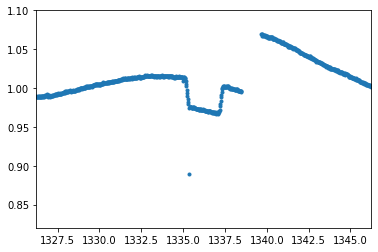

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(lc['time'][lc['mask']],lc['raw_flux'][lc['mask']],'.')
plt.xlim(3503.24-7000+4833-10,3503.24-7000+4833+10)
plt.ylim(1-0.18,1+0.1)

In [25]:
lc

{'bg_flux': array([197.7 ,   3.07,  25.68, ..., 519.57, 526.05, 599.94]),
 'cadence': array(['t30', 't30', 't30', ..., 't30', 't30', 't30'], dtype='<U3'),
 'cent_1': array([ 491.50601196,  491.50500488,  491.50601196, ..., 1481.62939453,
        1481.62805176, 1481.62878418]),
 'cent_2': array([1860.9029541 , 1860.9029541 , 1860.9029541 , ..., 1358.11877441,
        1358.11889648, 1358.11853027]),
 'flux': array([-7.95264310e-04,  1.19300179e-03,  5.03091919e-05, ...,
         9.75291588e-05, -2.80719516e-05,  3.27544634e-04]),
 'flux_err': array([0.00058835, 0.00058835, 0.00058835, ..., 0.00051957, 0.00051957,
        0.00051957]),
 'flux_sm_ap': array([0.99942673, 1.00086637, 1.00003361, ..., 0.99978227, 0.99995919,
        1.00029322]),
 'flux_unit': 1.0,
 'flux_xl_ap': array([0.99796623, 1.00150783, 1.00089227, ..., 1.00056482, 1.00035675,
        0.99974524]),
 'mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'quality': array([0, 0, 0, ..., 0, 0, 0]),
 'raw_flux': 

3683583172476237312
DEBUG [urllib3.connectionpool._get_conn()]: Resetting dropped connection: mast.stsci.edu
DEBUG [urllib3.connectionpool._make_request()]: https://mast.stsci.edu:443 "POST /api/v0/invoke HTTP/1.1" 200 None
229019525  not in TIC
DEBUG [urllib3.connectionpool._make_request()]: https://mast.stsci.edu:443 "POST /api/v0/invoke HTTP/1.1" 200 None
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): heasarc.gsfc.nasa.gov:443
DEBUG [urllib3.connectionpool._make_request()]: https://heasarc.gsfc.nasa.gov:443 "GET /cgi-bin/tess/webtess/wtv.py?Entry=192.0836%2C+-1.11515 HTTP/1.1" 200 None
https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (192.0836, -1.11515)>
[] <class 'list'>
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): exofop.ipac.caltech.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://exofop.ipac.caltech.edu:443 "GET /k2/download_target.php?id=229019

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '60534' (I am process '61270')


WARNING [theano.gof.compilelock.lock()]: Overriding existing lock by dead process '60534' (I am process '61270')
00 - Checks complete.  SNR: 6.766186  SNR_r: 4.123815  variability: 4.256729  centroid: None | flag: lowSNR
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.


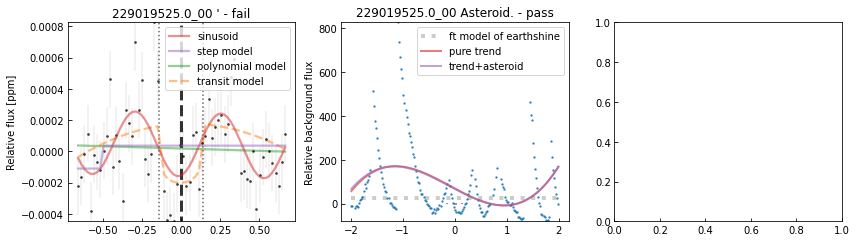

In [21]:
dat=cands.loc[cands['id']==229019525].iloc[0]
file_loc=tools.MonoData_savepath+'/'+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
if not os.path.isdir(file_loc):
    os.system('mkdir '+file_loc)
file_prefix=file_loc+"/"+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
if not pd.isnull(dat['ra']):
    radec=SkyCoord(float(dat['ra'])*u.deg,float(dat['dec'])*u.deg)
else:
    radec=None
#loading Rstar,Tess, logg and rho from csvs:
try:
    info,_,_=starpars.getStellarInfoFromCsv(int(dat['id']),dat['mission'],radec=radec)
    info.to_csv(file_prefix+'_starpars.csv')
    Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
    Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
    logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
    rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
    FeH=0.0 if 'FeH' not in info else float(info['FeH'])
    if 'mass' in info:
        Ms=float(info['mass'])
    else:
        Ms=rhostar[0]*Rstar[0]**3
except:
    #STARPARS fails:
    info=pd.Series({'source':None},name=dat['id'])
    Rstar=[1.0]
    Teff=[5800]
    logg=[4.43]
    rhostar=[1.0]
    FeH=0.0
    Ms=1.0
else:
    #print("loading from ",file_prefix+'_starpars.csv')
    info=pd.read_csv(file_prefix+'_starpars.csv', index_col=0, header=0).T.iloc[0]
    Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
    Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
    logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
    rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
    FeH=0.0 if 'FeH' not in info else float(info['FeH'])
    if 'mass' in info:
        Ms=float(info['mass'])
    else:
        Ms=rhostar[0]*Rstar[0]**3

if 'ra' in info.index and radec is None:
    radec=SkyCoord(float(info['ra'])*u.deg,float(info['dec'])*u.deg)

if not os.path.exists(file_prefix+'_lc.pickle') or dat['mission'].lower()=='corot':
    lc,hdr=tools.openLightCurve(int(dat['id']),dat['mission'],coor=radec,use_ppt=False)
    pickle.dump(lc,open(file_prefix+'_lc.pickle','wb'))
else:
    lc=pickle.load(open(file_prefix+'_lc.pickle','rb'))

if np.min(abs(dat['tcen']-lc['time']))<dat['dur']:
    cand={'00':{'tcen':dat['tcen'],'tdur':dat['dur'],'orbit_flag':'mono'}}    
elif np.min(abs((dat['tcen']-(7000-4833))-lc['time']))<dat['dur']:
    cand={'00':{'tcen':dat['tcen']-(7000-4833),'tdur':dat['dur'],'orbit_flag':'mono'}}    
else:
    cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                                  plot=False)

if cand['00']['tdur'] in [np.nan,0.0]:
    xmask = abs(lc['time']-dat['tcen'])<5 if dat['tcen'] not in [np.nan,0.0,2167.0] else None
    cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                          custom_mask=xmask,plot=False)
    #In the case of a large star, sometimes we niss ultra-short duration transits:
    if Rstar[0]>1.75:
        cand2, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                              custom_mask=xmask,plot=False)
        if len(cand)==0 or cand2['00']['snr']>cand['00']['snr']:
            cand=cand2

'''
if dat['mission'].lower()=='tess' and dat['dur']>0.38 and 't30' in lc['cadence'] and 'bg_flux' in lc and not np.isnan(lc['bg_flux'][lc['cadence']=='t30']).all():
    #Here we have a QLP lightcurve with a long-duration transit. Maybe we should use raw_flux...
    lc['flux'][lc['cadence']=='t30']=lc['raw_flux'][lc['cadence']=='t30']
'''

out, fig = search.VetCand(cand['00'],'00',dat['id'],lc,Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                           file_loc=file_loc,plot=True,vet_do_fit=True)
floatvars=[var for var in out if type(out[var]) in [int,float,str,np.float64,np.float32]]
df=pd.Series({var:out[var] for var in floatvars},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
df.to_csv(file_prefix+"_CandMonoInfo.csv")


In [19]:
out = tools.getK2lc(229019525,10)

INFO  [everest.user.DownloadFile()]: Downloading the file...
ERROR [everest.user.DownloadFile()]: Error code 0 for URL 'https://archive.stsci.edu/hlsps/everest/v2/c101/229000000/19525/hlsp_everest_k2_llc_229019525-c101_kepler_v2.0_lc.fits'
101 not possible to load
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTP connection (1): archive.stsci.edu:80
DEBUG [urllib3.connectionpool._make_request()]: http://archive.stsci.edu:80 "GET /missions/hlsp/k2sff/c102/229000000/19525/hlsp_k2sff_k2_lightcurve_229019525-c102_kepler_v1_llc.fits HTTP/1.1" 302 309
DEBUG [urllib3.connectionpool._new_conn()]: Starting new HTTPS connection (1): archive.stsci.edu:443
DEBUG [urllib3.connectionpool._make_request()]: https://archive.stsci.edu:443 "GET /missions/hlsp/k2sff/c102/229000000/19525/hlsp_k2sff_k2_lightcurve_229019525-c102_kepler_v1_llc.fits HTTP/1.1" 200 760320
334
8 points masked in lc of 334
Extracted vanderburg LC from  http://archive.stsci.edu/missions/hlsp/k2sff/c102/229000000/19525/h

In [20]:
out

{'bg_flux': array([ 5.46720486e-04,  7.04869645e-04,  3.30248851e-04, -1.10903347e-04,
        -6.25699804e-04, -6.62741383e-04, -1.13072922e-03, -1.68109676e-03,
        -4.47237719e-04,  2.23632498e-04,  8.23573185e-04,  1.82174821e-03,
         2.59381619e-03,  4.15536942e-03,  1.17358309e-02,  1.09306188e-02,
         8.47538032e-03,  8.12013908e-03,  7.16706313e-03,  6.03358641e-03,
         4.69640562e-03,  4.28894526e-03,  4.54410263e-03,  3.52867863e-03,
         2.09145184e-03,  1.81851509e-03,  1.24982227e-03,  1.33487940e-04,
        -4.37124856e-04, -1.05456276e-03, -8.20953262e-04, -7.09110248e-04,
         1.04890020e-04, -1.32945593e-03, -7.85162816e-04, -7.98482710e-04,
        -8.48941161e-04,  1.15599775e-04,  1.16352017e-03,  1.42821530e-03,
         2.05813891e-03,  2.56784372e-03,  3.96236928e-03,  5.81605372e-03,
         4.82780744e-03,  6.62281932e-03,  7.10676932e-03,  8.27868273e-03,
         1.02067968e-02,  3.37889055e-02,  2.94454769e-02,  2.47650950e-02,
 

In [9]:
lc,hr=tools.openLightCurve(162683152,'tess')

https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=<SkyCoord (ICRS): (ra, dec) in deg
    (170.6845, -42.94799167)>
[10] <class 'list'>
TESS file
3372 points masked in lc of 18900


In [10]:
hr

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2019-05-25'         / file creation date.                            
TSTART  =    1569.431056949387 / observation start time in TJD                  
TSTOP   =    1595.681045762102 / observation stop time in TJD                   
DATE-OBS= '2019-03-26T22:19:

In [18]:
from stellar import tess_stars2px_mod

In [22]:
tess_stars2px_mod.SectFromCoords(coord=radec,tic=162683152)

KeyboardInterrupt: 

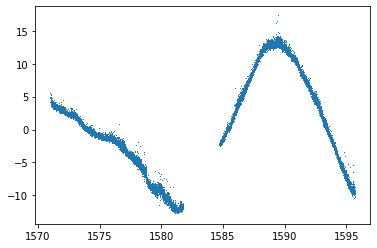

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(lc['time'],lc['flux'],',')

In [98]:
info,_,_=starpars.getStellarInfoFromCsv(int(dat['id']),dat['mission'],radec=radec)

Breaking because status = COMPLETE
TESS object
11.862 824.085 2.2821399540926883
rad 6.84416
mass 1.6732154733257183 1.6732154733257183
teff 4552.0
eneg_rad 2.2585728
epos_rad 2.2585728
eneg_mass 0.8366077366628591 0.8366077366628591
epos_mass 0.8366077366628591 0.8366077366628591
eneg_teff 124.0
epos_teff 124.0
ALLWISE      J045855.35-594135.5
APASS                   27236989
Bmag                      13.071
BmagFlag                apassdr9
Dec_orig                -59.6932
                    ...         
eneg_mass               0.836608
epos_mass               0.836608
logg                         NaN
eneg_logg                    NaN
epos_logg                    NaN
Name: 220461013, Length: 91, dtype: object


In [92]:
info = starpars.TICdata(int(dat['id'])).iloc[0]
starpars.MainSequenceFit(info['d'],info['Tmag'])

Breaking because status = COMPLETE
10.7361 824.085 1.1562399540926886


{'rad': array(2.0719061),
 'mass': array(2.26984351),
 'teff': array(9599.47836067),
 'eneg_rad': 1.0359530524601261,
 'epos_rad': 1.0359530524601261,
 'eneg_mass': 1.1349217541002101,
 'epos_mass': 1.1349217541002101,
 'eneg_teff': 1919.8956721336137,
 'epos_teff': 1919.8956721336137}

In [67]:
fits=pickle.load(open(os.path.join(tools.MonoData_tablepath,"BolMag_interpolations.models"),"rb"))

In [81]:
fits[2](4.8)

array(5762.85714286)

In [76]:
info['Tmag'],info['d']

(10.7361, 824.085)

In [89]:
10.2 - 5*np.log10(800) + 5

0.6845500650402805

In [60]:
info

source    None
Name: 220461013.0, dtype: object

In [36]:
Rstar

[1.0]

In [50]:
dat=cands.loc[cands.id==for ix,dat in cands.iterrows():
    try:
        file_loc=tools.MonoData_savepath+'/'+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
        if not os.path.isdir(file_loc):
            os.system('mkdir '+file_loc)
        file_prefix=file_loc+"/"+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
        if not os.path.isfile(file_prefix+"_CandMonoInfo.csv"):
            if not pd.isnull(dat['ra']):
                radec=SkyCoord(float(dat['ra'])*u.deg,float(dat['dec'])*u.deg)
            else:
                radec=None
            #loading Rstar,Tess, logg and rho from csvs:
            if not os.path.isfile(file_prefix+'_starpars.csv'):
                try:
                    info,_,_=starpars.getStellarInfoFromCsv(int(dat['id']),dat['mission'],radec=radec)
                    info.to_csv(file_prefix+'_starpars.csv')
                    Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
                    Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
                    logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
                    rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
                    FeH=0.0 if 'FeH' not in info else float(info['FeH'])
                    if 'mass' in info:
                        Ms=float(info['mass'])
                    else:
                        Ms=rhostar[0]*Rstar[0]**3
                except:
                    #STARPARS fails:
                    info={'source':None}
                    Rstar=[1.0]
                    Teff=[5800]
                    logg=[4.43]
                    rhostar=[1.0]
                    FeH=0.0
                    Ms=1.0
            else:
                #print("loading from ",file_prefix+'_starpars.csv')
                info=pd.read_csv(file_prefix+'_starpars.csv', index_col=0, header=0).T.iloc[0]
                Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
                Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
                logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
                rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
                FeH=0.0 if 'FeH' not in info else float(info['FeH'])
                if 'mass' in info:
                    Ms=float(info['mass'])
                else:
                    Ms=rhostar[0]*Rstar[0]**3

            if 'ra' in info.index and radec is None:
                radec=SkyCoord(float(info['ra'])*u.deg,float(info['dec'])*u.deg)

            if not os.path.exists(file_prefix+'_lc.pickle') or dat['mission'].lower()=='corot':
                lc,hdr=tools.openLightCurve(int(dat['id']),dat['mission'],coor=radec,use_ppt=False)
                pickle.dump(lc,open(file_prefix+'_lc.pickle','wb'))
            else:
                lc=pickle.load(open(file_prefix+'_lc.pickle','rb'))

            if np.min(abs(dat['tcen']-lc['time']))<dat['dur']:
                cand={'00':{'tcen':dat['tcen'],'tdur':dat['dur'],'orbit_flag':'mono'}}    
            elif np.min(abs((dat['tcen']-(7000-4833))-lc['time']))<dat['dur']:
                cand={'00':{'tcen':dat['tcen']-(7000-4833),'tdur':dat['dur'],'orbit_flag':'mono'}}    
            else:
                cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                                      custom_mask=xmask,plot=False)
            if cand['00']['tdur'] in [np.nan,0.0]:
                xmask = abs(lc['time']-dat['tcen'])<5 if dat['tcen'] not in [np.nan,0.0,2167.0] else None
                cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                                      custom_mask=xmask,plot=False)
                #In the case of a large star, sometimes we niss ultra-short duration transits:
                if Rstar[0]>1.75:
                    cand2, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                                          custom_mask=xmask,plot=False)
                    if len(cand)==0 or cand2['00']['snr']>cand['00']['snr']:
                        cand=cand2

            out, fig = search.VetCand(cand['00'],'00',dat['id'],lc,Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                       file_loc=file_loc,plot=True,vet_do_fit=True)
            floatvars=[var for var in out if type(out[var]) in [int,float,str,np.float64,np.float32]]
            df=pd.Series({var:out[var] for var in floatvars},name=tools.id_dic[dat['mission']]+str(int(dat['id'])))
            df.to_csv(file_prefix+"_CandMonoInfo.csv")
        else:
            print("Already processed",int(dat['id']))
    except:
        print("NO JUICE",int(dat['id']))].iloc[0]
file_loc=tools.MonoData_savepath+'/'+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
if not os.path.isdir(file_loc):
    os.system('mkdir '+file_loc)
file_prefix=file_loc+"/"+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)
if not os.path.exists(file_prefix+'_lc.pickle'):
    lc,hdr=tools.openLightCurve(int(dat['id']),dat['mission'],coor=radec,use_ppt=False)
    pickle.dump(lc,open(file_prefix+'_lc.pickle','wb'))
else:
    lc=pickle.load(open(file_prefix+'_lc.pickle','rb'))
plt.plot(lc['time'],lc['flux'],'.')


KeyboardInterrupt: 

In [ ]:
info=pd.read_csv(file_prefix+'_starpars.csv', index_col=0, header=0).T.iloc[0]
Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
FeH=0.0 if 'FeH' not in info else float(info['FeH'])
if 'mass' in info:
    Ms=float(info['mass'])
else:
    Ms=rhostar[0]*Rstar[0]**3

dat,Rstar

,Unnamed: 0,dec,dur,file,id,mission,ra,tcen
2240,3673,NaN,NaN,Martti_Monos_Tess_South,436847239.0,tess,NaN,NaN


[0.624, -0.02, 0.02]

In [42]:
dat=cands.loc[cands.id==436847239].iloc[0]
xmask = abs(lc['time']-dat['tcen'])<5 if not in [np.nan,0.0,2167.0] else None
cand, outparams, _ = search.MonoTransitSearch(lc,int(dat['id']),dat['mission'],Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                                      custom_mask=xmask,plot=False)


[0.02043228 0.02043218 0.02043238 ... 0.02043186 0.02043186 0.02043186] 0.09699776489585868 3712 4022
[0.02043228 0.02043218 0.02043238 ... 0.02043186 0.02043186 0.02043186] 0.18059104825594965 3712 4022
[0.02043228 0.02043218 0.02043238 ... 0.02043186 0.02043186 0.02043186] 0.2540905497823497 3712 4022
[0.02043228 0.02043218 0.02043238 ... 0.02043186 0.02043186 0.02043186] 0.32490096935258134 3712 4022
[0.02043228 0.02043218 0.02043238 ... 0.02043186 0.02043186 0.02043186] 0.3920435628946875 3712 4022
436847239 - Searching 39101 positions with 5 durations: 0.097,0.181,0.254,0.325,0.392


In [43]:
dat['tcen'] not in [np.nan,0.0,2167.0]

True

In [41]:
type(dat)

pandas.core.frame.DataFrame

In [29]:
dat['tcen']

2005.6527870000002

In [22]:
np.array_split(np.arange(0,10,0.1),np.array([20]))

[array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
        3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5,
        4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8,
        5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1,
        7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4,
        8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7,
        9.8, 9.9])]

In [79]:
monoparams=cand['00']
remove_earthshine=True
dur_region=3
order=3

nearish_region=np.max([4.5,monoparams['tdur']*dur_region]) #For the background fit, we'll take a region 9d long
nearishTrans=(abs(lc['time']-monoparams['tcen'])<nearish_region)&lc['mask']
cad=np.nanmedian(np.diff(lc['time'][nearishTrans]))

if 'bg_flux' in lc and np.sum(np.isfinite(lc['bg_flux'][nearishTrans]))>0:
    # Fits two models - one with a 2D polynomial spline and the interpolated "dip" model from the fit, and one with only a spline
    #If there's a big gap, we'll remove the far side of that
    if np.max(np.diff(lc['time'][nearishTrans]))>0.4:
        jump_n=np.argmax(np.diff(lc['time'][nearishTrans]))
        jump_time=np.average(lc['time'][nearishTrans][jump_n:jump_n+1])
        if jump_time < monoparams['tcen']:
            nearishTrans=(lc['time']>jump_time)&((lc['time']-monoparams['tcen'])<nearish_region)&lc['mask']
        elif jump_time > monoparams['tcen']:
            nearishTrans=((lc['time']-monoparams['tcen'])>(-1*nearish_region))&(lc['time']<jump_time)&lc['mask']

    nearishTrans[nearishTrans]=np.isfinite(lc['bg_flux'][nearishTrans])

    bg_lc=np.column_stack((lc['time'][nearishTrans],
                           lc['bg_flux'][nearishTrans],
                           np.tile(np.nanstd(lc['bg_flux'][nearishTrans]),np.sum(nearishTrans))
                          ))

    bg_lc[:,0]-=monoparams['tcen']
    nearTrans=(abs(bg_lc[:,0])<monoparams['tdur']*dur_region)
    outTransit=(abs(bg_lc[:,0])>monoparams['tdur']*0.75)
    inTransit=(abs(bg_lc[:,0])<monoparams['tdur']*0.35)
    #print(bg_lc)
    bg_lc[:,1:]/=np.nanmedian(bg_lc[outTransit,1])

    if remove_earthshine and lc['cadence'][np.argmin(abs(lc['time']-monoparams['tcen']))].lower()[0]=='t':
        #Removing Earthshine with a filter on frequencies of 1/0.5/0.33 days (for TESS lightcurves only):
        newt=np.arange(bg_lc[0,0],bg_lc[-1,0],cad)

        #Preparing the signal timeseries:            
        init_poly=np.polyfit(bg_lc[outTransit,0],bg_lc[outTransit,1],order) #do polynomial fit to make time series flat 
        news = (bg_lc[:,1]-np.polyval(init_poly,bg_lc[:,0]))[np.argmin(abs(bg_lc[:,0][:,np.newaxis]-newt[np.newaxis,:]),axis=0)] #Making sure the timeseries is uniform

        # Doing an FFT fit for the known frequencies associated with Earth rotation:
        n=news.size
        fr=np.fft.fftfreq(n,cad)  # a nice helper function to get the frequencies  
        fou=np.fft.fft(news) 
        freqs=[1,2,3] #Frequencies to filter - all multiples of 1

        #make up a narrow bandpass with a Gaussian
        df=0.066
        gpl= np.sum([np.exp(- ((fr-f)/(2*df))**2) for f in freqs],axis=0) # pos. frequencies
        gmn= np.sum([np.exp(- ((fr+f)/(2*df))**2) for f in freqs],axis=0) # neg. frequencies
        g=gpl+gmn    

        #ifft
        s2=np.fft.ifft(fou*g) #filtered spectrum = spectrum * bandpass 
        fft_bg_model = np.real(s2)[np.argmin(abs(newt[:,np.newaxis] - bg_lc[:,0][np.newaxis,:]),axis=0)]
        #fft_bg_model += np.polyval(init_poly, bg_lc[nearTrans,0]
        print(len(fft_bg_model),len(bg_lc[nearTrans,0]))
    else:
        fft_bg_model=np.tile(0,np.sum(nearTrans))

6373 1103


NameError: name 'filt' is not defined

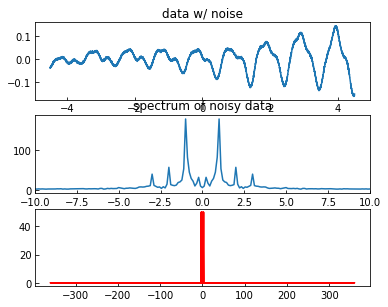

In [80]:
plt.figure(figsize=(6,10))
plt.subplot(612)
plt.plot(newt,news)
plt.title('data w/ noise')

plt.subplot(613)
plt.plot(np.fft.fftshift(fr) ,np.fft.fftshift(np.abs(fou) )  )
plt.title('spectrum of noisy data')
plt.xlim(-10,10)

plt.subplot(614)
plt.plot(fr,g*50, 'r')  
plt.plot(fr,np.abs(filt))
plt.title('filter (red)  + filtered spectrum')
plt.xlim(-10,10)

plt.subplot(615)
plt.plot(newt,np.real(s2))
plt.title('filtered time data')

plt.subplot(616)
plt.plot(newt,news-np.real(s2))
plt.title('noise minus fit')

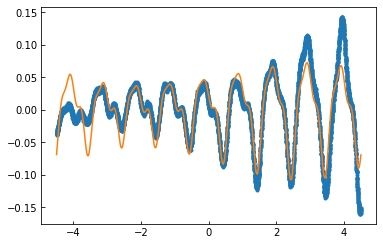

In [82]:
plt.plot(newt,news,'.')
plt.plot(bg_lc[:,0],fft_bg_model)

In [10]:
dat['tcen']

2167.0

In [13]:
lc['lc_base']

KeyError: 'lc_base'

In [12]:
173.7805874+7000-4833

2340.7805873999996

In [15]:
out['snr_r']

3.555008543440299

In [5]:
print(get_qlps)

['KIC10321319', 'KIC10197310', 'KIC10287723', 'KIC10602068', 'KIC10842718', 'KIC3218908', 'KIC5521451', 'KIC7456155', 'KIC7971363', 'KIC8410697', 'KIC8800954', 'KIC9306307', 'KIC5010054', 'KIC5951458', 'KIC8540376', 'KIC9838291', 'KIC10403228', 'KIC11558724', 'KIC9970525', 'KIC6191521', 'KIC3230491', 'KIC5942949', 'KIC1717722', 'KIC8636333', 'KIC4042088', 'CID102574444', 'CID102586624', 'CID102765275', 'CID102802996', 'CID102829388', 'CID102895957', 'CID102973379', 'CID315188649', 'TIC24969647', 'TIC191746706', 'EPIC246732631', 'EPIC246696483', 'EPIC245964933', 'EPIC220186865', 'EPIC220208795', 'EPIC201176672', 'EPIC249149130', 'EPIC249131213', 'EPIC249204601', 'EPIC211395575', 'EPIC245940811', 'EPIC251606086', 'EPIC245953291', 'EPIC246037366', 'EPIC246770778', 'EPIC211309989', 'EPIC202081797', 'EPIC202760268', 'EPIC202875475', 'EPIC211402929', 'EPIC212289237', 'EPIC220194833', 'TIC91704666', 'EPIC251606086', 'EPIC251403538', 'EPIC249149130', 'EPIC246696483', 'EPIC245929407', 'EPIC2202

In [123]:
dat=cands.loc[cands['id']==7971363].iloc[0]
cand={'00':{'tcen':dat['tcen']-(7000-4833),'tdur':dat['dur'],'orbit_flag':'mono'}}

transit mask: <class 'numpy.ndarray'> 68826 1 <class 'numpy.ndarray'> 68826 True
0 340 104 320 236 220
1 340 104 314 236 216
2 340 104 328 236 226
3 340 104 323 236 224
4 340 104 327 236 228
5 340 104 329 236 231
6 340 104 323 236 224
7 340 104 322 236 222
True [[-3.36791992e+00 -5.54471465e-04 -2.80575617e-04 -8.56133644e-03
   1.04101729e-02 -6.43433584e-03]
 [-3.34753418e+00 -3.81902432e-04 -2.62069749e-04 -8.14352930e-03
   1.02015305e-02 -6.43313490e-03]
 [-3.32714844e+00 -2.15246025e-04 -2.43686022e-04 -7.72705814e-03
   9.99288820e-03 -6.43193396e-03]
 ...
 [ 3.55871582e+00 -3.44198226e-04 -1.02253606e-03 -1.01393703e-02
  -6.08374132e-04 -6.02630852e-03]
 [ 3.57910156e+00 -7.51502190e-04 -1.04553139e-03 -1.05501236e-02
  -6.17121696e-04 -6.02510758e-03]
 [ 3.59960938e+00 -1.31742720e-03 -1.06878766e-03 -1.09619144e-02
  -6.25921530e-04 -6.02389965e-03]]
True [[-6.22854668  0.97682142  0.97636217  0.97694281]
 [-6.20811397  0.97669311  0.97643698  0.97700918]
 [-6.18768137  0.97

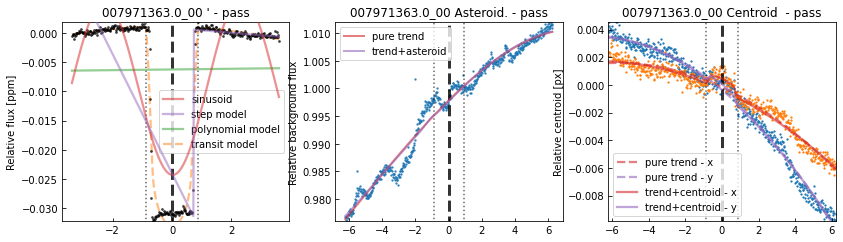

In [133]:
out, fig = search.VetCand(cand['00'],'00',dat['id'],lc,Rs=Rstar[0],Ms=Ms,Teff=Teff[0], force_tdur=True,
                           file_loc=file_loc,plot=True,vet_do_fit=True,return_fit_lcs=False)

In [134]:
out

{'tcen': -1491.344492314799,
 'tdur': 1.7831021226073565,
 'orbit_flag': 'mono',
 'log_lik_mono': -9467.535229780131,
 'model_success': 'False',
 'trend': array([-0.00014695, -0.00011273,  0.001109  ]),
 'flux_trend': array([-2.80575617e-04, -2.62069749e-04, -2.43686022e-04, -2.25315455e-04,
        -2.07176743e-04, -1.89160174e-04, -1.71158962e-04, -1.53387408e-04,
        -1.35632679e-04, -1.18106140e-04, -1.00701744e-04, -8.33163701e-05,
        -6.61569886e-05, -4.90180975e-05, -3.21037312e-05, -1.53115069e-05,
         1.45802849e-06,  1.80052375e-05,  3.44303047e-05,  5.08304843e-05,
         6.70105361e-05,  8.31642333e-05,  9.90992699e-05,  1.14912165e-04,
         1.30696506e-04,  1.46264385e-04,  1.61802244e-04,  1.77125108e-04,
         1.92325831e-04,  2.07494334e-04,  2.22450041e-04,  2.37283606e-04,
         2.52082753e-04,  2.66671303e-04,  2.81223968e-04,  2.95567502e-04,
         3.09788895e-04,  3.23972204e-04,  3.37948581e-04,  3.51885408e-04,
         3.65616770e-04

In [132]:
abs(18226*Ms/Rstar[0]**3*((2*np.sqrt((1+0.03**0.5)**2-0.41**2))/cand['00']['tdur'])**-3)

35.789016826547716

In [128]:
Rstar[0],Ms

(5.686, 2.058)

In [122]:
dat['dur']

1.230638248

In [92]:
cand

{'tcen': -1491.2300258999999,
 'tdur': 5.658665959524427,
 'orbit_flag': 'mono',
 'log_lik_mono': -inf,
 'model_success': 'False',
 'trend': array([-2.80482168e-05, -9.19233307e-05,  2.69468903e-04]),
 'flux_trend': array([ 2.49436644e-04,  2.51533447e-04,  2.53606937e-04,  2.55669321e-04,
         2.57696047e-04,  2.59699460e-04,  2.61691347e-04,  2.63647996e-04,
         2.65592839e-04,  2.67502723e-04,  2.69389294e-04,  2.71263641e-04,
         2.73103448e-04,  2.74930749e-04,  2.76723792e-04,  2.78493522e-04,
         2.80250327e-04,  2.81973293e-04,  2.83672946e-04,  2.85359254e-04,
         2.87012143e-04,  2.88651407e-04,  2.90257531e-04,  2.91840342e-04,
         2.93409109e-04,  2.94945157e-04,  2.96466879e-04,  2.97956162e-04,
         2.99422132e-04,  3.00873358e-04,  3.02292563e-04,  3.03688456e-04,
         3.05069186e-04,  3.06418314e-04,  3.07751999e-04,  3.09054363e-04,
         3.10333414e-04,  3.11596602e-04,  3.12828889e-04,  3.14045033e-04,
         3.15230555e-04, 

In [85]:
cand['00']['tcen']

-1491.2300258999999

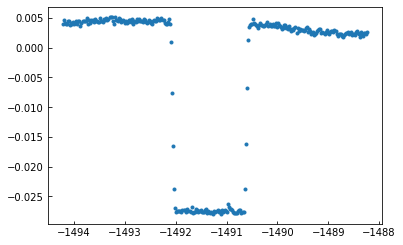

In [89]:
round_tr=abs(lc['time']-cand['00']['tcen'])<3
plt.plot(lc['time'][round_tr],lc['flux'][round_tr],'.')

In [79]:
lc['jd_base']

2457000

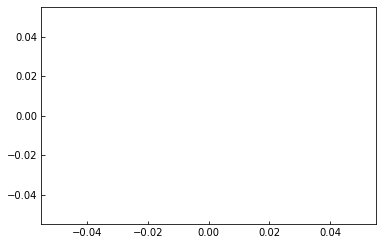

In [75]:
plt.plot(lc['time'][abs(lc['time']-dat['tcen'])<dat['dur']],
         lc['raw_flux'][abs(lc['time']-dat['tcen'])<dat['dur']],'.')

In [78]:
np.min(abs(lc['time']-dat['tcen']))

1007.5975315997572

transit mask: <class 'numpy.ndarray'> 36635 0 <class 'numpy.ndarray'> 36635 True
00 - Checks complete.  SNR: 82.20988  SNR_r: 32.19009  variability: -9261.47  centroid: 15.57243 | flag: planet
DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.


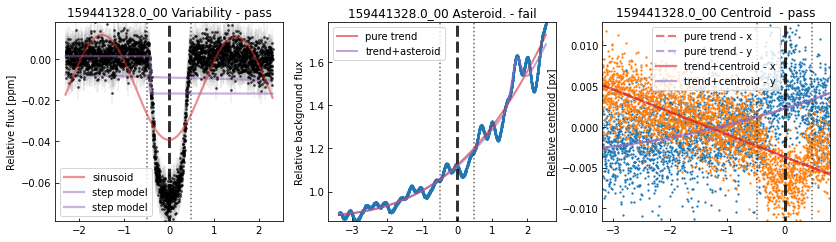

In [8]:
dat=cands.loc[cands['id']==25608334].iloc[0]
file_loc=tools.MonoData_savepath+'/'+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)

info=pd.read_csv(file_prefix+'_starpars.csv', index_col=0, header=0).T.iloc[0]

file_prefix=file_loc+"/"+tools.id_dic[dat['mission']]+str(int(dat['id'])).zfill(11)

Rstar=[float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
Teff=[float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
logg=[float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
rhostar=[float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
FeH=0.0 if 'FeH' not in info else float(info['FeH'])

lc=pickle.load(open(file_prefix+'_lc.pickle','rb'))
cand={'00':{'tcen':dat['tcen']-(7000-4833),'tdur':dat['dur'],'orbit_flag':'mono'}}    
cand, fig = search.VetCand(cand['00'],'00',dat['id'],lc,Rs=Rstar[0],Ms=Ms,Teff=Teff[0],
                           file_loc=file_loc,plot=True,vet_do_fit=True)

poly 0 14906.662631661242
poly 0 14906.662631531179
poly 0 14906.662631639692
poly 0 14906.662631653486
poly -4849623185.162688 -1127728766.8528235
poly -4849623086.677937 -1127728742.635463
poly -4849623185.162687 -1127728776.2425325
poly -4849623185.162688 -1127728762.8237362
poly 0 14906.662631659863
poly 0 14906.662631556555
poly 0 14906.662631627945
poly 0 14906.66263165656
poly 0 14906.662631661187
poly 0 14906.66263153649
poly 0 14906.662631637559
poly 0 14906.662631654324
poly 0 14906.662631661238
poly 0 14906.6626315323
poly 0 14906.662631639254
poly 0 14906.662631653671
poly 0 14906.662631661242
poly 0 14906.662631531413
poly 0 14906.662631639603
poly 0 14906.662631653526
poly 0 14906.662631661238
poly 0 14906.662631531999
poly 0 14906.662631639374
poly 0 14906.66263165362
poly 0 14906.662631661242
poly 0 14906.662631531537
poly 0 14906.662631639554
poly 0 14906.662631653544
poly 0 14906.66263166124
poly 0 14906.662631531843
poly 0 14906.662631639436
poly 0 14906.662631653595

centroid -1.0074741112386665 28216.531762680374
centroid -1.0074741112386665 28216.53111676086
centroid -0.9586036240829356 28241.62837430132
centroid -0.9586035577267016 28241.62847880787
centroid -0.9586037716082889 28241.628269775156
centroid -0.9586036240829356 28241.628197033417
centroid -0.9586036240829356 28241.6288182273
centroid -0.9586036240829356 28241.627837996657
centroid -0.9586036240829356 28241.627633325454
centroid -0.9586036240829356 28241.628894540943
centroid -0.9586036240829356 28241.628044843124
centroid -0.8769082447107082 28277.590995275976
centroid -0.8769081812545039 28277.59109855519
centroid -0.8769083858184847 28277.59088372319
centroid -0.8769082447107082 28277.591027325936
centroid -0.8769082447107082 28277.59152420186
centroid -0.8769082447107082 28277.5903524757
centroid -0.8769082447107082 28277.590657074914
centroid -0.8769082447107082 28277.59152854348
centroid -0.8769082447107082 28277.59102835515
centroid -0.4780690648885 27172.570737802744
centroi

centroid -0.4483382092740373 29795.20409996569
centroid -0.4483382092740373 29795.204103114767
centroid -0.4483382092740373 29795.204011575086
centroid -0.4483382092740373 29795.2037941214
centroid -0.4483382092740373 29795.204267467434
centroid -0.4483382092740373 29795.20410827928
centroid -0.4412628610665371 29795.94525845942
centroid -0.44126291244742677 29795.945261708235
centroid -0.44126276739336256 29795.945258473876
centroid -0.4412628610665371 29795.945288640927
centroid -0.4412628610665371 29795.945258065327
centroid -0.4412628610665371 29795.94519448286
centroid -0.4412628610665371 29795.945063546344
centroid -0.4412628610665371 29795.94539697221
centroid -0.4412628610665371 29795.945279119835
centroid -0.4228993074057675 29797.06691233173
centroid -0.42289935897021236 29797.066914982686
centroid -0.42289921713759343 29797.06691284657
centroid -0.4228993074057675 29797.06690308498
centroid -0.4228993074057675 29797.066884516677
centroid -0.4228993074057675 29797.06688442707

centroid -0.3788432818479003 28531.951506495607
centroid -0.31618935903030126 28795.57580226924
centroid -0.33639951165083265 28694.94512033646
centroid -0.30717392316760733 28804.905012627667
centroid -0.2807529295934522 29053.131696230343
centroid -0.34648305709583527 28952.72304519727
centroid -0.3433066887141253 28976.318120799566
centroid -0.30419124165591527 29085.93417938929
centroid -0.42115143890867657 29143.687334348506
centroid -0.3876247384063346 29100.050083441747
centroid -0.47251041839880614 29067.824580622426
centroid -0.523925302035092 29084.09743560428
centroid -0.6721453373839884 28961.7553608289
centroid -0.8031757390106026 28841.312251084684
centroid -0.5545158660017332 29051.388401412274
centroid -0.6846095204557664 28913.624229895016
centroid -0.36096463468963325 29078.727736307243
centroid -0.2934818432814037 28968.720766032704
centroid -0.3191901310885884 29080.801411755965
centroid -0.5555540324422038 29081.89389614883
centroid -0.29221720560936854 29093.97190

centroid -0.23380765073843066 29766.828724156705
centroid -0.22620997131682763 29766.485875847364
centroid -0.23377363909641416 29766.72864706543
centroid -0.22554470766009732 29766.667838309375
centroid -0.23458298903996677 29767.458241479533
centroid -0.23455123447750514 29768.02867013273
centroid -0.22324079170309102 29767.00949111886
centroid -0.22761026816082125 29767.624918300662
centroid -0.23787466591133058 29767.73439270535
centroid -0.2420822729193669 29767.562241859832
centroid -0.2347607794638098 29767.799648740616
centroid -0.23588384448280134 29767.610135012357
centroid -0.23598719550187594 29768.47630086507
centroid -0.23708893252212251 29769.05705717505
centroid -0.22433267271747143 29768.357071394552
centroid -0.2454544787405013 29768.979737512902
centroid -0.22788785992471663 29768.399615345872
centroid -0.23146821854954408 29768.834748414352
centroid -0.2407151988022387 29769.230099338176
centroid -0.24751001767833578 29769.488926131147
centroid -0.23265637440867173 

centroid -0.3949566604698741 29792.316949084845
centroid -0.39526410923101474 29792.308121811984
centroid -0.3971918208387152 29792.30284810525
centroid -0.3938104570903377 29792.31506357109
centroid -0.3965706130631014 29792.30034217339
centroid -0.3941991396086656 29792.31605769077
centroid -0.3947281484130962 29792.32005019099
centroid -0.39457498260166346 29792.317447309433
centroid -0.3912799890377435 29792.30902922219
centroid -0.39333528910299304 29792.312732475595
centroid -0.39738629411051846 29792.311695001696
centroid -0.39279830936709675 29792.315557128313
centroid -0.39279143291106633 29792.31706066446
centroid -0.3955042870625477 29792.3130020011
centroid -0.39331250764205816 29792.31641688542
centroid -0.3947442705205999 29792.314605067026
centroid -0.39439175376742536 29792.3179747978
centroid -0.3920254828083866 29792.31620837055
centroid -0.3934903201634137 29792.31293128771
centroid -0.39372974261833216 29792.318068408313
centroid -0.3929830097577149 29792.3180881349

centroid -0.42597822504564276 29797.654122413434
centroid -0.4167648884601177 29797.66628656932
centroid -0.4164385052155492 29797.614896591753
centroid -0.4185822722149619 29797.674512331636
centroid -0.4190097200501298 29797.661276199593
centroid -0.41812661733533973 29797.670624026272
centroid -0.4172154188522203 29797.676843072382
centroid -0.4166629078771795 29797.648890332053
centroid -0.4184209517990971 29797.68164067834
centroid -0.4203723666183339 29797.65080134225
centroid -0.417042377590165 29797.680460687065
centroid -0.41667132636500404 29797.690580689574
centroid -0.4154697444955676 29797.669362471912
centroid -0.421166545889222 29797.70348044853
centroid -0.4242636257385122 29797.69295617041
centroid -0.42052083605612334 29797.665062536747
centroid -0.4177017277175744 29797.687943086363
centroid -0.4190490411983224 29797.661167445753
centroid -0.41835653394027805 29797.689887214125
centroid -0.41853585472010246 29797.68796571432
centroid -0.4202501267219356 29797.6800985

centroid -0.4262465338011225 -189728711.67193615
centroid -0.4262465338011225 29797.724619663695
centroid -0.4262465338011225 29797.72461961022
centroid -0.4262465338011225 29797.72461961022
centroid -0.4262465338011225 29797.724619663695
centroid -0.4262465338011225 -215445634.00542542
centroid -0.4262465338011225 -564097764.7917917
centroid -0.4262465338011225 29797.724619663695
centroid -0.4262465338011225 -82275800.08546291
centroid -0.4262465338011225 -31407332.9066473
centroid -0.4262465338011225 29797.726611727834
centroid -0.4262465338011225 29797.7266115285
centroid -0.4262465338011225 29797.726611528495
centroid -0.4262465338011225 29797.726611727834
centroid -0.4262465338011225 -77513102.90385431
centroid -0.4262465338011225 -202985086.28235975
centroid -0.4262465338011225 29797.726611727834
centroid -0.4262465338011225 -29590117.623105515
centroid -0.4262465338011225 -11283283.50328854
centroid -0.4262465338011225 29797.730981588065
centroid -0.4262465338011225 29797.730981

centroid -1.3222491998538217 27703.36136061884
centroid -1.3222490658829416 27703.36063360821
centroid -1.3222490658829416 27703.361570993322
centroid -1.3222490658829416 27703.361329478994
centroid -1.3222490658829416 27703.358687433458
centroid -1.3222490658829416 27703.362572588157
centroid -1.3222490658829416 27703.36134411456
centroid -1.316464702632787 27735.857857062572
centroid -1.316464593187178 27735.85798957111
centroid -1.3164648362678797 27735.85775502242
centroid -1.316464702632787 27735.85764150002
centroid -1.316464702632787 27735.857936726137
centroid -1.316464702632787 27735.857809962836
centroid -1.316464702632787 27735.856828748445
centroid -1.316464702632787 27735.858174778434
centroid -1.316464702632787 27735.857811855098
centroid -1.3144869979759446 27740.035362678016
centroid -1.3144868886029646 27740.03549464424
centroid -1.3144871314946547 27740.035264190396
centroid -1.3144869979759446 27740.0353714472
centroid -1.3144869979759446 27740.035396700405
centroid 

centroid -0.48322468589009626 29791.138098977513
centroid -0.48322468589009626 29791.138104995494
centroid -0.48322468589009626 29791.138094397105
centroid -0.48322468589009626 29791.138100365482
centroid -0.48320506456734225 29791.14127264493
centroid -0.48320511079612766 29791.14127842929
centroid -0.4832049590324621 29791.141280231346
centroid -0.48320506456734225 29791.141277324856
centroid -0.48320506456734225 29791.141271251723
centroid -0.48320506456734225 29791.141276182512
centroid -0.48320506456734225 29791.14128254089
centroid -0.48320506456734225 29791.141266777115
centroid -0.48320506456734225 29791.141275576978
centroid -0.4831125903899553 29791.15196098614
centroid -0.48311263662675286 29791.151966625566
centroid -0.48311248487622455 29791.1519685347
centroid -0.4831125903899553 29791.1519784404
centroid -0.4831125903899553 29791.151955345897
centroid -0.4831125903899553 29791.15197170808
centroid -0.4831125903899553 29791.151974669956
centroid -0.4831125903899553 29791.

centroid -0.42631124269883736 29797.819423060908
centroid -0.4263111006191812 29797.819422952096
centroid -0.4263111892293962 29797.819428628667
centroid -0.4263111892293962 29797.819421276166
centroid -0.4263111892293962 29797.819422358094
centroid -0.4263111892293962 29797.819425486232
centroid -0.4263111892293962 29797.81942289828
centroid -0.4263111892293962 29797.819425188834
centroid -0.4258337787973351 29797.818750368584
centroid -0.4258338322481669 29797.81875037647
centroid -0.4258336902506288 29797.81875026209
centroid -0.4258337787973351 29797.818748563004
centroid -0.4258337787973351 29797.818752969255
centroid -0.4258337787973351 29797.818748712532
centroid -0.4258337787973351 29797.818737005244
centroid -0.4258337787973351 29797.81875472678
centroid -0.4258337787973351 29797.818750458024
centroid -0.4261068773405635 29797.819462723528
centroid -0.42610693080204204 29797.819462738582
centroid -0.4261067887575227 29797.819462627387
centroid -0.4261068773405635 29797.8194651

centroid -0.2133558741791917 28931.599799673044
centroid -0.22841999209378636 28971.91172465247
centroid -0.2185894998081062 28944.930313581863
centroid -0.27447075811763966 28861.765340764934
centroid -0.27419223637654977 28887.78767127037
centroid -0.318555750889257 28857.93276340571
centroid -0.3656988826557366 28601.10203755259
centroid -0.23592024095992944 28880.913559651002
centroid -0.2666805033594719 28899.664630489577
centroid -0.20983319403403536 28859.80022576459
centroid -0.2849384343751269 28917.304499662358
centroid -0.36847157257369423 28799.938490362212
centroid -0.2133615559819881 28925.209131876203
centroid -0.19371143861136547 29024.22114819513
centroid -0.15897622618449228 29092.08620787492
centroid -0.2796609447744198 28855.709346288237
centroid -0.22253166149653517 28947.18333208521
centroid -0.17983949857810097 29016.139416943413
centroid -0.21175058176521527 28891.58125399784
centroid -0.23130063737199869 28961.175613936706
centroid -0.1768796369210818 28921.400

centroid -0.30113030451547773 29778.65601849431
centroid -0.31655031731469185 29778.119739989434
centroid -0.2919356743869238 29778.489184532365
centroid -0.29641724332328934 29778.65870209533
centroid -0.3014119323228983 29778.35876940984
centroid -0.29756833659074655 29778.534356361568
centroid -0.30525787199820303 29778.3044300181
centroid -0.296426441816353 29778.540023218557
centroid -0.29507671522028095 29778.621544218742
centroid -0.296226434213952 29778.677814284994
centroid -0.2944571702967324 29778.570051994524
centroid -0.300378460501987 29778.51562612891
centroid -0.2820900669953367 29778.4049586724
centroid -0.30413861342682785 29778.60907353863
centroid -0.3045662083903824 29778.76888397695
centroid -0.3109984215090661 29778.793735074705
centroid -0.29872138606826937 29778.589222506234
centroid -0.3017945932152281 29778.860900760916
centroid -0.3039487739296588 29778.947500283437
centroid -0.3048197715292975 29778.86514032488
centroid -0.30404359895527044 29778.7962852004

centroid -0.39995532900723496 29795.567290014966
centroid -0.4481252912801953 29795.76343782856
centroid -0.4233889531361227 29795.9748651493
centroid -0.4053301970372742 29795.861755232305
centroid -0.4353992369376707 29795.854175543922
centroid -0.43675779536558124 29795.325861962778
centroid -0.4282416592679201 29795.938490528002
centroid -0.43229997937255443 29796.455448024135
centroid -0.4428999452057779 29796.079897053274
centroid -0.4532399192688232 29796.103145619887
centroid -0.40605988515562264 29796.369526266804
centroid -0.44127092539863516 29796.116370167914
centroid -0.41834654296557794 29796.406716463705
centroid -0.45262891193729826 29796.068113355497
centroid -0.434858057472604 29796.857048107646
centroid -0.43830041423119337 29796.821491944655
centroid -0.442597198082758 29796.474615973166
centroid -0.4116876071272205 29796.2787409687
centroid -0.43349655188939085 29796.664953109597
centroid -0.40235054059457076 29796.513859372848
centroid -0.40441643970708946 29796.1

centroid -0.42656997225415405 29797.71542698011
centroid -0.42656997225415405 -33322646.408508293
centroid -0.42656997225415405 -12708798.132920397
centroid -0.42656997225415405 29797.72155305193
centroid -0.42656997225415405 29797.72155243918
centroid -0.42656997225415405 29797.72155243918
centroid -5.3661248239694626 26458.268488145695
centroid -0.42656997225415405 29797.72155305193
centroid -45.178039678112505 -25235.22649440505
centroid -95.2069056813269 -114383.76856043773
centroid -0.42656997225415405 29797.72155305193
centroid -12.236782256136758 8752.606950413441
centroid -8.202945446714722 21774.28314852513
centroid -0.42748772024669424 29797.724128986505
centroid -0.42749690977665455 29797.724138010213
centroid -0.4274785309543023 29797.72411963139
centroid -0.42748772024669424 29797.724128986505
centroid -71.5339946606709 -32189.144954434054
centroid -224.46869398240432 -132521.20980624584
centroid -0.42748772024669424 29797.724128986505
centroid -36.53047066665549 6112.5380

centroid -1.5317693284463039 27817.05490858524
centroid -1.4831302925351373 27839.138313252028
centroid -1.4831302193991271 27839.13842367121
centroid -1.483130483952981 27839.13818840895
centroid -1.4831302925351373 27839.137805051207
centroid -1.4831302925351373 27839.138883858534
centroid -1.4831302925351373 27839.137707445345
centroid -1.4831302925351373 27839.137155808156
centroid -1.4831302925351373 27839.13890594709
centroid -1.4831302925351373 27839.137988974202
centroid -1.4035692353286193 27873.24239657692
centroid -1.4035691642641779 27873.242505969138
centroid -1.4035694216056613 27873.242266796944
centroid -1.4035692353286193 27873.241697414152
centroid -1.4035692353286193 27873.243231303473
centroid -1.4035692353286193 27873.241623866787
centroid -1.4035692353286193 27873.241305572123
centroid -1.4035692353286193 27873.243040175737
centroid -1.4035692353286193 27873.242327342945
centroid -1.144806013160952 27604.227426888734
centroid -1.1448059492717952 27604.227500785943

centroid -0.45117812449496997 29791.134326065214
centroid -0.45117812449496997 29791.134382438206
centroid -0.45117812449496997 29791.134338061136
centroid -0.4485580397336869 29791.173556196947
centroid -0.44855808418311244 29791.17356373953
centroid -0.4485579379718466 29791.17356275663
centroid -0.4485580397336869 29791.17356883623
centroid -0.4485580397336869 29791.17354022175
centroid -0.4485580397336869 29791.17355515356
centroid -0.4485580397336869 29791.173496292566
centroid -0.4485580397336869 29791.1735832792
centroid -0.4485580397336869 29791.17351758068
centroid -0.44478079438442086 29791.274016082585
centroid -0.444780838825056 29791.27402361679
centroid -0.44478069321075464 29791.274022709164
centroid -0.44478079438442086 29791.274024383772
centroid -0.44478079438442086 29791.27399033278
centroid -0.44478079438442086 29791.274021561163
centroid -0.44478079438442086 29791.273965894583
centroid -0.44478079438442086 29791.274038749692
centroid -0.44478079438442086 29791.2739

DEBUG [matplotlib.backends.backend_pdf.fontName()]: Assigning font /b'F1' = '/Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Embedding font /Users/hosborn/transits/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG [matplotlib.backends.backend_pdf.writeFonts()]: Writing TrueType font.


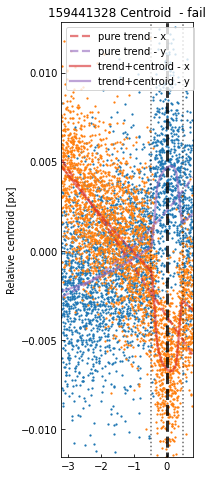

In [67]:
out=search.CentroidCheck(lc,cand,cand['interpmodel'],159441328,plot=True,return_fit_lcs=True)

In [68]:
out[0]

{'centroid_DeltaBIC': -577.6925865793819,
 'centroid_llk_ratio': -257.02038609754163,
 'x_centroid': 0.004661962681305636,
 'y_centroid': -0.003809809010201731,
 'x_centroid_SNR': 39.43550717840634,
 'y_centroid_SNR': 25.57106698409118}

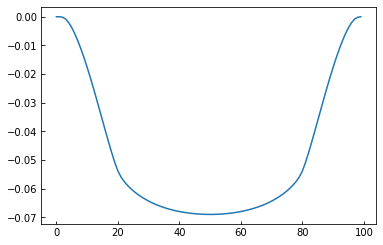

In [38]:
plt.plot(cand['interpmodel'](np.arange(-0.5,0.5,0.01)))

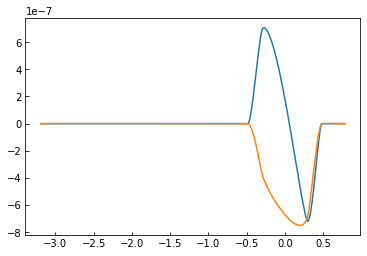

In [39]:
cent_fit_args=np.array([-1.18286320e-02,4.33562561e-03,6.26003702e-08,-2.75720392e-03,-3.68135091e-03,2.24220414e-04, 2.22823422e-03, 2.24355099e-03])
fitmod=search.dipmodel_centroid(cent_fit_args,out[-1][:,0],cand['interpmodel'],3)
plt.plot(out[-1][:,0],fitmod[0])
plt.plot(out[-1][:,0],fitmod[1])


In [36]:
fitmod

(array([-0.01613018, -0.01611085, -0.01609152, ..., -0.00435297,
        -0.00436409, -0.00437522]),
 array([-0.00487065, -0.00486755, -0.00486446, ...,  0.00398946,
         0.00399255,  0.00399565]))

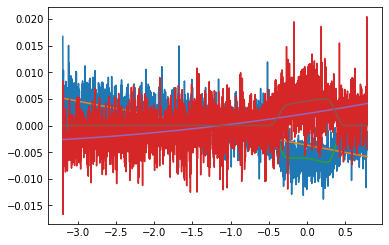

In [41]:
plt.plot(out[-1][:,0],out[-1][:,1])
plt.plot(out[-1][:,0],out[-1][:,2])
plt.plot(out[-1][:,0],out[-1][:,3])
plt.plot(out[-1][:,0],out[-1][:,4])
plt.plot(out[-1][:,0],out[-1][:,5])
plt.plot(out[-1][:,0],out[-1][:,6])

DEBUG [matplotlib.pyplot.switch_backend()]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


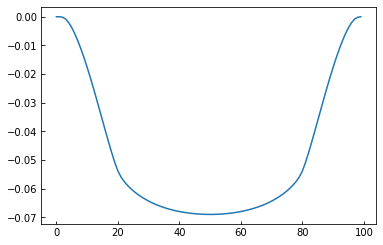

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cand['interpmodel'](np.arange(-0.5,0.5,0.01)))

In [34]:
,_,_=starpars.getStellarInfoFromCsv(int(dat['id']),'K2')

4132354718873029376
205272592  not in TIC


(AH                             0.175
 AJ                             0.348
 AKs                            0.086
 Ag                             1.811
 Ai                             0.984
                       ...           
 eneg_teff                        138
 tm_name      2MASS J16493394-1830585
 rho                          2.53411
 eneg_rho                    0.367068
 epos_rho                     0.45425
 Name: 205272592, Length: 83, dtype: object,
              EPIC  Cam            PS                 Gaia       LAMOST  \
 0       201048855   10           NaN  3582456140266586240          NaN   
 1       201049999   10           NaN  3582457617736883840          NaN   
 2       201050049   10           NaN  3582457858255051392          NaN   
 3       201050511   10           NaN  3582458579809568256          NaN   
 4       201051317   10  9.832182e+16  3582459163925111552          NaN   
 ...           ...  ...           ...                  ...          ...   
 244332  251

In [34]:
[var for var in cand if (type(cand[var]) in [int,float,str,np.float64,np.float32])&(type(var)!=np.ndarray)&(type(var)!=list)]


['tcen',
 'tdur',
 'orbit_flag',
 'log_lik_mono',
 'model_success',
 'log_per',
 'b',
 'log_ror',
 'ror',
 'r_pl',
 'period',
 'vrel',
 'third_light',
 'depth',
 'depth_err',
 'snr',
 'cdpp',
 'Ntrans',
 'snr_r',
 'init_tdur',
 'flag',
 'sin_fun',
 'sin_bic',
 'sin_llk',
 'sin_llk_ratio',
 'sin_DeltaBIC',
 'step_fun',
 'step_bic',
 'step_llk',
 'step_llk_ratio',
 'step_DeltaBIC',
 'poly_fun',
 'poly_bic',
 'poly_llk',
 'poly_llk_ratio',
 'poly_DeltaBIC',
 'trans_llk',
 'asteroid_DeltaBIC',
 'centroid_DeltaBIC',
 'instrumental_snr_ratio']

In [32]:
{var:cand[var] for var in floatvars},

({'tcen': -1612.6481971862283,
  'tdur': 0.6908246482482404,
  'orbit_flag': 'mono',
  'log_lik_mono': 2329.117334815929,
  'model_success': 'False',
  'trend': array([-1.02106571e-06,  1.04622802e-06,  1.31647060e-05]),
  'flux_trend': array([8.48685488e-07, 9.94409238e-07, 1.14014928e-06, 1.28417062e-06,
         1.42734329e-06, 1.57051698e-06, 1.71198723e-06, 1.85344831e-06,
         1.99321616e-06, 2.13213534e-06, 2.27103006e-06, 2.40824682e-06,
         2.54461492e-06, 2.68094329e-06, 2.81560898e-06, 2.95022474e-06,
         3.08318801e-06, 3.21530261e-06, 3.34735202e-06, 3.47776421e-06,
         3.60810101e-06, 3.73681079e-06, 3.86467190e-06, 3.99244234e-06,
         4.11860104e-06, 4.24465888e-06, 4.36911516e-06, 4.49272278e-06,
         4.61621426e-06, 4.73811947e-06, 4.85989834e-06, 4.98010113e-06,
         5.09945526e-06, 5.21866777e-06, 5.33631949e-06, 5.45381940e-06,
         5.56976869e-06, 5.68486933e-06, 5.79980288e-06, 5.91320110e-06,
         6.02642205e-06, 6.13811785

In [18]:
x = cand['monofit_x']-cand['tcen']
round_trans=(abs(x)<3*cand['tdur'])
x=x[round_trans]
y = cand['monofit_y'][round_trans]
yerr = cand['monofit_yerr'][round_trans]
y_trans = cand['monofit_ymodel'][round_trans]

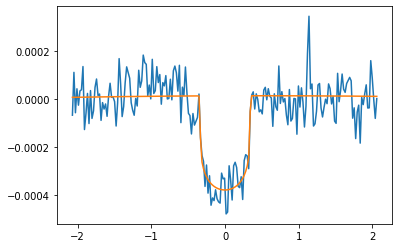

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x,y)
plt.plot(x,y_trans)